In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST 
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt

# **Classification**
In this part we will explore the performance of using different activation units to train on a subset of MNIST dataset

First, we load the dataset and turn it into numpy arrays

In [2]:
mnist_train_set = MNIST("Data", download = True, train = True)
mnist_test_set = MNIST("Data", download = True, train = False)
mnist_trainX = np.array(mnist_train_set.data.numpy())
mnist_trainY = np.array(mnist_train_set.targets.numpy())
mnist_testX = np.array(mnist_test_set.data.numpy())
mnist_testY = np.array(mnist_test_set.targets.numpy())
mnist_trainX = mnist_trainX.reshape((mnist_trainX.shape[0], -1))
mnist_testX = mnist_testX.reshape((mnist_testX.shape[0], -1))


### (a) Visualization

Visualize a mnist data and its label. 

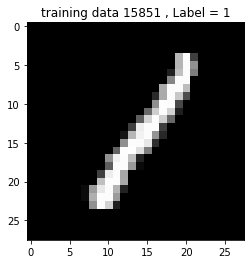

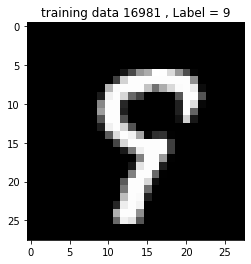

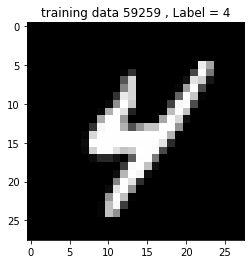

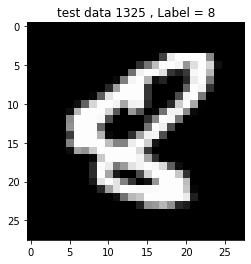

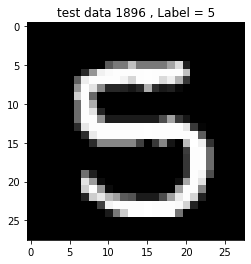

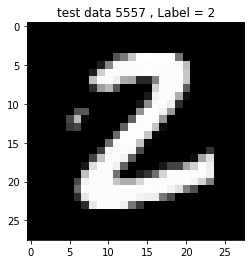

In [3]:
############################################################### TODO A
idx = np.sort(np.random.choice(mnist_trainX.shape[0], 3))
for i in idx:
    plt.imshow(mnist_trainX[i].reshape(28, 28), cmap='gray')
    plt.title('training data {} , Label = {}'.format(i, mnist_trainY[i]))
    plt.show()
    
idx = np.sort(np.random.choice(mnist_testX.shape[0], 3))
for i in idx:
    plt.imshow(mnist_testX[i].reshape(28, 28), cmap='gray')
    plt.title('test data {} , Label = {}'.format(i, mnist_testY[i]))
    plt.show()
############################################################### TODO A

In the cell below, split the validation set with fraction 0.2

### (b) Split training set and the validation set

Split training set and the validation set

In [4]:
############################################# TODO B
# Please Fill in the cell to implement X_train, Y_train, X_valid, Y_valid, X_test, and Y_test in numpy array
# Also provide the number of data in n_train, n_valid, and n_test
train_frac = 0.2
valid_frac = 0.2
n_train = int(np.ceil(mnist_trainX.shape[0] * train_frac * (1 - valid_frac)))
n_valid = int(np.ceil(mnist_trainX.shape[0] * train_frac * valid_frac))

mnist_subsetX = mnist_trainX[:n_train+n_valid]
mnist_subsetY = mnist_trainY[:n_train+n_valid]

X_train = mnist_subsetX[:n_train]
Y_train = mnist_subsetY[:n_train]
# split the validation set
X_valid = mnist_subsetX[n_train:]
Y_valid = mnist_subsetY[n_train:]
# renaming the test data
X_test = mnist_testX
Y_test = mnist_testY

n_test = mnist_testX.shape[0]
#############################################

# Turn the numpy array to pytorch tensor

X_train = torch.Tensor(X_train)
Y_train = torch.from_numpy(Y_train)
# split the validation set
X_valid = torch.Tensor(X_valid)
Y_valid = torch.from_numpy(Y_valid)
# renaming the test data
X_test = torch.Tensor(X_test)
Y_test = torch.from_numpy(Y_test)

print("Number of training data: {}".format(n_train))
print("Number of validation data: {}".format(n_valid))
print("Number of test data: {}".format(n_test))

Number of training data: 9600
Number of validation data: 2400
Number of test data: 10000


### **(c) Implementing activation functions: Mish and Swish**
Pytorch provides many activation units under torch.nn.Module.

We can just use torch.nn.{Module Name} to instantiates the module. [Here is the reference of the official documentation on the types of activation functions and how to use them](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

Moreover, we can also define new activation units.

In this problem, we will implement Mish and Swish activation function

The original paper for Mish : https://arxiv.org/abs/1908.08681

The original paper for Swish: https://arxiv.org/abs/1710.05941

The Mish function is defined as:

$f_{Mish}(x) = x(tanh(ln(1+e^x)))$

And the Swish function is defined as: 

$f_{Swish}(x) = x(sigmoid(\beta x)) = \frac{x}{( 1 + e^{\beta x})}$, where $\beta$ is a learnable weight 

Implement the two function by completing forward and backward(gradient) method.
You can use torch.gradcheck to see if your gradient is computed correctly. The torch.gradcheck compares the analytical gradients to numerical gradients, in which the analytical gradients are obtained by the backward methods and the numerical gradients are obtained by introducing small difference to the input.

If your implementation is corrent. The gradcheck function will return True.
For more implemenation details, you can see the official note from pytorch: https://pytorch.org/docs/stable/notes/extending.html

In [5]:
# This is an example of how to implement an autograd function in pytorch
# the forward function compute the output of the function 
# the backward function computes the gradient with respect to the input (and other parameters like weights)
# For activation function, this can be easily done by chain rule.
# As the example, the gradient w.r.t input equals the gradient w.r.t its output multiplied 
#    by the gradient of its output w.r.t its input 
# The ctx.saved_tensors can save the input and some tempory results from forward method
# In the backward method, call ctx.saved_tensors to load the input and tempory results
class SigmoidFunction(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        output = 1.0/ ( 1 + torch.exp(-input))
        ctx.save_for_backward(output)   # save for backward function
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_input = output * (1 - output) * grad_output
        return grad_input

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ################################################### TODO C_1
        tanh_ = torch.tanh(torch.log(1+torch.exp(input)))
        output = input* tanh_ 
        
        ctx.save_for_backward(input, tanh_)
        ###################################################
        return output

    @staticmethod
    def backward(ctx, grad_output):
        ################################################### TODO C_2
        input, tanh_ = ctx.saved_tensors
        
        grad_input = (tanh_ + input * (1 - tanh_*tanh_) * torch.exp(input) / (1 + torch.exp(input))) * grad_output
        ###################################################
        return grad_input    
    
class SwishFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, beta):
        ################################################### TODO C_3
        beta_sigmoid = 1 / ( 1 + torch.exp(-beta * input))
        output = input * beta_sigmoid
        ctx.save_for_backward(input, beta, beta_sigmoid, output)
        ################################################### 
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # The beta in swish function is learnable. Therefore you have to also compute the gradients w.r.t beta
        ################################################### TODO C_4
        input, beta, beta_sigmoid, output = ctx.saved_tensors
        grad_input = (beta_sigmoid + input * beta_sigmoid * (1-beta_sigmoid) * beta) * grad_output
        grad_beta =  input * beta_sigmoid * (1-beta_sigmoid) * input * grad_output
        ################################################### TODO
        return grad_input, grad_beta
    
sigmoid = SigmoidFunction.apply
mish = MishFunction.apply
swish = SwishFunction.apply


class Sigmoid(torch.nn.Module):
    
    def __init__(self):
        super(MySigmoid, self).__init__()

    def forward(self, input):
        return sigmoid(input)

class Mish(torch.nn.Module):
    
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return sigmoid(input)
    
class Swish(torch.nn.Module):
    
    def __init__(self):
        super(Swish, self).__init__()
        self.beta = torch.nn.Parameter(torch.Tensor(1))
        self.beta.data.uniform_(-0.1, 0.1)
        
    def forward(self, input):
        return swish(input, self.beta)

input = (torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(sigmoid, input, eps=1e-6, atol=1e-4)
print("Gradient check for sigmoid function: ", test_result)
input = (torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(mish, input, eps=1e-6, atol=1e-4)
print("Gradient check for mish function: ", test_result)
input = (torch.randn(50,50,dtype=torch.double,requires_grad=True), torch.randn(50,50,dtype=torch.double,requires_grad=True))
test_result = gradcheck(swish, input, eps=1e-6, atol=1e-4)
print("Gradient check for swish function: ", test_result)

C:\Users\User\anaconda3\lib\site-packages\torch\autograd\__init__.py:202: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Gradient check for sigmoid function:  True
Gradient check for mish function:  True
Gradient check for swish function:  True


### (d) Training neural networks using different activation function



In [6]:
D_in = mnist_trainX.shape[1]
D_out = 10

def training(activation_module, D_hidden_in, D_hidden_out, x, y, learning_rate, epochs):
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, D_hidden_in),
        activation_module(),
        torch.nn.Linear(D_hidden_in, D_hidden_out),
        activation_module(),
        torch.nn.Linear(D_hidden_out, D_out),
    )
    
    loss_train_his = []
    loss_valid_his = []
    acc_train_his = []
    acc_valid_his = []

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for i in range(epochs):
        
        if i%10 == 9:
            with torch.no_grad():
                model.eval()
                loss_valid, acc_valid = test(model, X_valid, Y_valid)
                loss_valid_his.append(loss_valid)
                acc_valid_his.append(acc_valid)
                loss_train, acc_train = test(model, x, y)
                loss_train_his.append(loss_train)
                acc_train_his.append(acc_train)
                print(i, "loss = ", loss_train, "acc = ", acc_train, "valid: ", (loss_valid, acc_valid))
        model.train()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Training complete")
    return model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his

def test(model, X_test, Y_test):
    
    y_pred = model(X_test)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(y_pred, Y_test)
    _, label = torch.max(y_pred, 1)
    return loss.item(), (torch.count_nonzero(label == Y_test)/ Y_test.shape[0]).item()


Using the above training function, train the classifier using different activation function including ReLU, Sigmoid, LeakyReLU, and Tanh, Swish, and Mish.

Record the returned losses and accuracy in the array losses and accs.

First, using the same learning rate 0.005 for all activation function

In [7]:
epochs = 1000
learning_rate = 5e-3
activation_units = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.LeakyReLU, torch.nn.Tanh, Mish, Swish]
activation_strs = ["ReLU", "Sigmoid", "LeakyReLU", "Tanh",  "Mish", "Swish"]
learning_rate = [5e-3, 5e-3, 5e-3, 5e-3, 5e-3, 5e-3]
models = []
losses = np.zeros((len(activation_units), 2, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, int(epochs/10)))


for i, act in enumerate(activation_units):
    print("Training with {} activation units".format(activation_strs[i]))
# Call the training function to get the model, loss and accuracy
    model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                200, 64, X_train, Y_train, learning_rate[i], epochs)
    models.append(model)
    losses[i,0,:] = np.array(loss_train_his)
    losses[i,1,:] = np.array(loss_valid_his)
    accs[i,0,:] = np.array(acc_train_his)
    accs[i,1,:] = np.array(acc_valid_his)

Training with ReLU activation units
9 loss =  1.8299269676208496 acc =  0.36895832419395447 valid:  (1.8389477729797363, 0.3629166781902313)
19 loss =  0.9587284326553345 acc =  0.7011458277702332 valid:  (0.9956490993499756, 0.6887500286102295)
29 loss =  0.6438055634498596 acc =  0.8073958158493042 valid:  (0.6992124915122986, 0.7850000262260437)
39 loss =  0.516666829586029 acc =  0.8491666913032532 valid:  (0.5832800269126892, 0.824999988079071)
49 loss =  0.4430237412452698 acc =  0.8737499713897705 valid:  (0.5180552005767822, 0.846666693687439)
59 loss =  0.3912733197212219 acc =  0.8905208110809326 valid:  (0.4713813364505768, 0.8587499856948853)
69 loss =  0.3522486984729767 acc =  0.9012500047683716 valid:  (0.43649908900260925, 0.872083306312561)
79 loss =  0.32167115807533264 acc =  0.9085416793823242 valid:  (0.4095137119293213, 0.8820833563804626)
89 loss =  0.29621508717536926 acc =  0.9165624976158142 valid:  (0.3876698315143585, 0.8870833516120911)
99 loss =  0.2746197

769 loss =  0.028357041999697685 acc =  0.9963541626930237 valid:  (0.2315095067024231, 0.9383333325386047)
779 loss =  0.027710996568202972 acc =  0.996666669845581 valid:  (0.23153455555438995, 0.9387500286102295)
789 loss =  0.027087140828371048 acc =  0.9967708587646484 valid:  (0.2315131425857544, 0.9391666650772095)
799 loss =  0.02648197114467621 acc =  0.996874988079071 valid:  (0.2315320521593094, 0.9395833611488342)
809 loss =  0.025882218033075333 acc =  0.996874988079071 valid:  (0.23156575858592987, 0.9395833611488342)
819 loss =  0.02529858984053135 acc =  0.9972916841506958 valid:  (0.23165921866893768, 0.9395833611488342)
829 loss =  0.02473229356110096 acc =  0.9972916841506958 valid:  (0.23175010085105896, 0.9395833611488342)
839 loss =  0.024180952459573746 acc =  0.9972916841506958 valid:  (0.23181335628032684, 0.9395833611488342)
849 loss =  0.02364778332412243 acc =  0.9972916841506958 valid:  (0.2319328784942627, 0.9395833611488342)
859 loss =  0.0231319032609462

529 loss =  2.147467851638794 acc =  0.512499988079071 valid:  (2.1471309661865234, 0.5037500262260437)
539 loss =  2.144334077835083 acc =  0.5166666507720947 valid:  (2.1439363956451416, 0.5074999928474426)
549 loss =  2.141169548034668 acc =  0.5217708349227905 valid:  (2.1407339572906494, 0.5112500190734863)
559 loss =  2.1380090713500977 acc =  0.5246875286102295 valid:  (2.1375224590301514, 0.5141666531562805)
569 loss =  2.1348204612731934 acc =  0.5287500023841858 valid:  (2.134281635284424, 0.518750011920929)
579 loss =  2.131596565246582 acc =  0.5330208539962769 valid:  (2.1310126781463623, 0.5220833420753479)
589 loss =  2.128338098526001 acc =  0.5366666913032532 valid:  (2.1277170181274414, 0.5233333110809326)
599 loss =  2.1250481605529785 acc =  0.5398958325386047 valid:  (2.1244077682495117, 0.5245833396911621)
609 loss =  2.121711254119873 acc =  0.5432291626930237 valid:  (2.1210825443267822, 0.5270833373069763)
619 loss =  2.118339776992798 acc =  0.5459374785423279

299 loss =  0.11643195897340775 acc =  0.9692708253860474 valid:  (0.2629384696483612, 0.9254166483879089)
309 loss =  0.11266247928142548 acc =  0.9703124761581421 valid:  (0.2605222761631012, 0.9258333444595337)
319 loss =  0.10908643156290054 acc =  0.9719791412353516 valid:  (0.2585412561893463, 0.9266666769981384)
329 loss =  0.1056712418794632 acc =  0.9730208516120911 valid:  (0.25657036900520325, 0.9266666769981384)
339 loss =  0.10242387652397156 acc =  0.973645806312561 valid:  (0.25464561581611633, 0.9275000095367432)
349 loss =  0.09933280944824219 acc =  0.9748958349227905 valid:  (0.2530617117881775, 0.9270833134651184)
359 loss =  0.09637599438428879 acc =  0.9764583110809326 valid:  (0.25145432353019714, 0.9275000095367432)
369 loss =  0.09353184700012207 acc =  0.9775000214576721 valid:  (0.24991129338741302, 0.9283333420753479)
379 loss =  0.09082423150539398 acc =  0.9785416722297668 valid:  (0.24846339225769043, 0.9287499785423279)
389 loss =  0.0882408618927002 acc

49 loss =  1.8278552293777466 acc =  0.6068750023841858 valid:  (1.8389040231704712, 0.5824999809265137)
59 loss =  1.765224575996399 acc =  0.6343749761581421 valid:  (1.776628851890564, 0.6079166531562805)
69 loss =  1.706303358078003 acc =  0.6585416793823242 valid:  (1.7173513174057007, 0.6324999928474426)
79 loss =  1.6527345180511475 acc =  0.6781250238418579 valid:  (1.662872552871704, 0.6487500071525574)
89 loss =  1.6017276048660278 acc =  0.6922916769981384 valid:  (1.6120727062225342, 0.6645833253860474)
99 loss =  1.5537590980529785 acc =  0.70333331823349 valid:  (1.5637456178665161, 0.6758333444595337)
109 loss =  1.5086318254470825 acc =  0.7119791507720947 valid:  (1.5180085897445679, 0.6899999976158142)
119 loss =  1.465880274772644 acc =  0.7217708230018616 valid:  (1.4749248027801514, 0.7016666531562805)
129 loss =  1.4249240159988403 acc =  0.7329166531562805 valid:  (1.4349145889282227, 0.7120833396911621)
139 loss =  1.3858610391616821 acc =  0.7416666746139526 va

819 loss =  0.4468386471271515 acc =  0.9231250286102295 valid:  (0.5283564329147339, 0.8862500190734863)
829 loss =  0.44253483414649963 acc =  0.9240624904632568 valid:  (0.5247460007667542, 0.8866666555404663)
839 loss =  0.43832579255104065 acc =  0.924791693687439 valid:  (0.5212461948394775, 0.8866666555404663)
849 loss =  0.43417537212371826 acc =  0.9248958230018616 valid:  (0.5178209543228149, 0.8870833516120911)
859 loss =  0.43011170625686646 acc =  0.9256250262260437 valid:  (0.5145427584648132, 0.887499988079071)
869 loss =  0.42613592743873596 acc =  0.9264583587646484 valid:  (0.5113651752471924, 0.8879166841506958)
879 loss =  0.42225655913352966 acc =  0.9268749952316284 valid:  (0.5082132816314697, 0.8887500166893005)
889 loss =  0.4184446632862091 acc =  0.9276041388511658 valid:  (0.5051541328430176, 0.8895833492279053)
899 loss =  0.4146547317504883 acc =  0.9281250238418579 valid:  (0.5021316409111023, 0.8895833492279053)
909 loss =  0.41099247336387634 acc =  0.9

589 loss =  2.1349446773529053 acc =  0.5766666531562805 valid:  (2.135737419128418, 0.5583333373069763)
599 loss =  2.131690263748169 acc =  0.581041693687439 valid:  (2.1323983669281006, 0.5625)
609 loss =  2.1284143924713135 acc =  0.5841666460037231 valid:  (2.129037618637085, 0.5670833587646484)
619 loss =  2.1251049041748047 acc =  0.588854193687439 valid:  (2.1256556510925293, 0.5704166889190674)
629 loss =  2.121765613555908 acc =  0.5924999713897705 valid:  (2.1222472190856934, 0.574999988079071)
639 loss =  2.1183714866638184 acc =  0.5960416793823242 valid:  (2.1188108921051025, 0.5791666507720947)
649 loss =  2.1149773597717285 acc =  0.5998958349227905 valid:  (2.115368366241455, 0.5829166769981384)
659 loss =  2.1115705966949463 acc =  0.6022916436195374 valid:  (2.111931085586548, 0.5874999761581421)
669 loss =  2.108142614364624 acc =  0.606041669845581 valid:  (2.108473539352417, 0.5883333086967468)
679 loss =  2.1046760082244873 acc =  0.6096875071525574 valid:  (2.10

359 loss =  2.3034536838531494 acc =  0.09749999642372131 valid:  (2.302541494369507, 0.10708333551883698)
369 loss =  2.303377389907837 acc =  0.09749999642372131 valid:  (2.3025131225585938, 0.10708333551883698)
379 loss =  2.3033931255340576 acc =  0.09749999642372131 valid:  (2.3025059700012207, 0.10708333551883698)
389 loss =  2.303309679031372 acc =  0.09749999642372131 valid:  (2.302466630935669, 0.10708333551883698)
399 loss =  2.3033108711242676 acc =  0.09749999642372131 valid:  (2.302464485168457, 0.10708333551883698)
409 loss =  2.303312063217163 acc =  0.09749999642372131 valid:  (2.3024392127990723, 0.10708333551883698)
419 loss =  2.3031861782073975 acc =  0.09749999642372131 valid:  (2.3024308681488037, 0.10708333551883698)
429 loss =  2.303192138671875 acc =  0.09749999642372131 valid:  (2.302410125732422, 0.10708333551883698)
439 loss =  2.303163766860962 acc =  0.09749999642372131 valid:  (2.3023769855499268, 0.10708333551883698)
449 loss =  2.303030014038086 acc =  

Visualize the change of loss and accuracy versus epochs.

You should have four plots (1) training loss (2) validation loss (3) training accuracy (4) validation accuracy

Observe the loss and accuracy.

_Your Observation:_

We can see that the ReLU and LeakyReLU have similar loss during training, and their loss have converged. Their performance are the best compared with other activation functions.  For Tanh, sigmoid, and Mish activation units, the loss do decrease but have not converged, which indicate that we should slightly increase the learning rate or increase the number of epochs. For  Swish activation unit, the loss does not decrease and the accuracy remains low as that of random guess. This means either the model parameter is unsuitable for this activation function. Problems might include weight initialization, optimization parameters. In the next problem we will see that this is actually caused by a high learning rate. By reducing the learning rate, the activation unit can work.

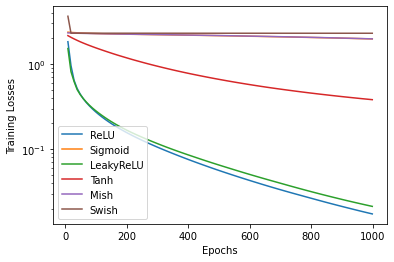

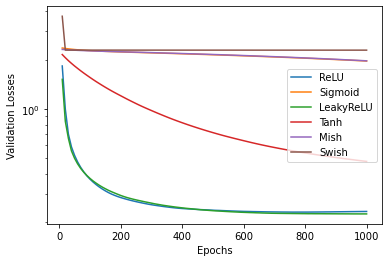

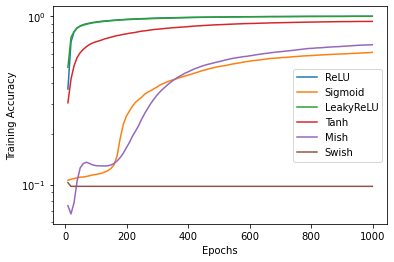

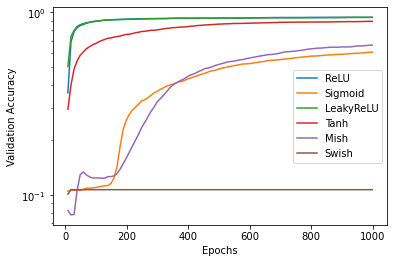

In [8]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,1], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Validation Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,1], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.yscale("log")
plt.legend()
plt.show()

### **(e) Grid search of learning rate for different activation functions**
You should have noticed that some activation units did not converge.

This means that the learning rate may be too low for those activation units.

Adjust the learning rates for those activation units, and try to optimize the learning rate for each activation unit.

In [9]:
num_lr = 8
epochs = 1000
losses = np.zeros((len(activation_units), 2, num_lr, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, num_lr, int(epochs/10)))

###################################################### TODO E
learning_rates = [np.logspace(-3.0, 0.0, num=num_lr)]*len(activation_units)
for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        print("Training with {} activation units at learning rate {}".format(activation_strs[i], lr))

    # Call the training function to get the model, loss and accuracy
        model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                    200, 64, X_train, Y_train, lr, epochs)
        models.append(model)
        losses[i,0,j,:] = np.array(loss_train_his)
        losses[i,1,j,:] = np.array(loss_valid_his)
        accs[i,0,j,:] = np.array(acc_train_his)
        accs[i,1,j,:] = np.array(acc_valid_his)
######################################################

Training with ReLU activation units at learning rate 0.001
9 loss =  1.7112762928009033 acc =  0.5664583444595337 valid:  (1.6370700597763062, 0.5708333253860474)
19 loss =  1.0720471143722534 acc =  0.6992708444595337 valid:  (1.0157183408737183, 0.7116666436195374)
29 loss =  0.8532912135124207 acc =  0.7521874904632568 valid:  (0.8191936016082764, 0.7691666483879089)
39 loss =  0.7299834489822388 acc =  0.78885418176651 valid:  (0.7128463983535767, 0.7912499904632568)
49 loss =  0.6483453512191772 acc =  0.8103125095367432 valid:  (0.6441388726234436, 0.8087499737739563)
59 loss =  0.5888804793357849 acc =  0.8286458253860474 valid:  (0.5955832004547119, 0.8229166865348816)
69 loss =  0.54280686378479 acc =  0.8419791460037231 valid:  (0.5584093332290649, 0.8324999809265137)
79 loss =  0.5053645372390747 acc =  0.85135418176651 valid:  (0.5288668274879456, 0.840833306312561)
89 loss =  0.4740748107433319 acc =  0.8606250286102295 valid:  (0.5045562982559204, 0.8508333563804626)
99 l

769 loss =  0.09498753398656845 acc =  0.9771875143051147 valid:  (0.26929280161857605, 0.9175000190734863)
779 loss =  0.09362389892339706 acc =  0.9775000214576721 valid:  (0.2686237692832947, 0.9175000190734863)
789 loss =  0.09229224175214767 acc =  0.9776041507720947 valid:  (0.2679928243160248, 0.9175000190734863)
799 loss =  0.09098353981971741 acc =  0.9781249761581421 valid:  (0.2673589885234833, 0.9175000190734863)
809 loss =  0.08970163017511368 acc =  0.9788541793823242 valid:  (0.266762375831604, 0.9175000190734863)
819 loss =  0.08844722807407379 acc =  0.9791666865348816 valid:  (0.2661561667919159, 0.9183333516120911)
829 loss =  0.08722136914730072 acc =  0.9797916412353516 valid:  (0.2655569314956665, 0.9183333516120911)
839 loss =  0.08602186292409897 acc =  0.9803125262260437 valid:  (0.26496621966362, 0.9179166555404663)
849 loss =  0.0848488137125969 acc =  0.9804166555404663 valid:  (0.26437702775001526, 0.9191666841506958)
859 loss =  0.0837012231349945 acc =  0

529 loss =  0.07329670339822769 acc =  0.984375 valid:  (0.2863979935646057, 0.92208331823349)
539 loss =  0.07165651023387909 acc =  0.9846875071525574 valid:  (0.2859351933002472, 0.9225000143051147)
549 loss =  0.07006347924470901 acc =  0.9852083325386047 valid:  (0.2855290174484253, 0.9225000143051147)
559 loss =  0.06852485239505768 acc =  0.9857291579246521 valid:  (0.2851278483867645, 0.92166668176651)
569 loss =  0.06703687459230423 acc =  0.9864583611488342 valid:  (0.2847757637500763, 0.92166668176651)
579 loss =  0.06560007482767105 acc =  0.9866666793823242 valid:  (0.2844690978527069, 0.92166668176651)
589 loss =  0.0642080008983612 acc =  0.9873958230018616 valid:  (0.2840832471847534, 0.92166668176651)
599 loss =  0.06286552548408508 acc =  0.9878125190734863 valid:  (0.28376486897468567, 0.92166668176651)
609 loss =  0.06156433746218681 acc =  0.9885416626930237 valid:  (0.28346312046051025, 0.92208331823349)
619 loss =  0.060296159237623215 acc =  0.9887499809265137 v

289 loss =  0.09458933025598526 acc =  0.9751041531562805 valid:  (0.2548583447933197, 0.9304166436195374)
299 loss =  0.09105191379785538 acc =  0.9768750071525574 valid:  (0.25361335277557373, 0.9308333396911621)
309 loss =  0.08774824440479279 acc =  0.9776041507720947 valid:  (0.2523280382156372, 0.9312499761581421)
319 loss =  0.08450838178396225 acc =  0.9792708158493042 valid:  (0.2513660192489624, 0.9316666722297668)
329 loss =  0.08140377700328827 acc =  0.9802083373069763 valid:  (0.25073546171188354, 0.9320833086967468)
339 loss =  0.0784740149974823 acc =  0.9808333516120911 valid:  (0.25003260374069214, 0.9337499737739563)
349 loss =  0.07573655247688293 acc =  0.9818750023841858 valid:  (0.24937520921230316, 0.9337499737739563)
359 loss =  0.07313399761915207 acc =  0.9830208420753479 valid:  (0.24875737726688385, 0.9354166388511658)
369 loss =  0.07063261419534683 acc =  0.9838541746139526 valid:  (0.24835659563541412, 0.9354166388511658)
379 loss =  0.06819269061088562 

39 loss =  2.3063952922821045 acc =  0.10166666656732559 valid:  (2.306920051574707, 0.09666666388511658)
49 loss =  2.305645227432251 acc =  0.10166666656732559 valid:  (2.3061347007751465, 0.09666666388511658)
59 loss =  2.3051681518554688 acc =  0.10166666656732559 valid:  (2.3057003021240234, 0.09666666388511658)
69 loss =  2.304839611053467 acc =  0.10166666656732559 valid:  (2.3053719997406006, 0.09666666388511658)
79 loss =  2.3044824600219727 acc =  0.10166666656732559 valid:  (2.3050918579101562, 0.09666666388511658)
89 loss =  2.3042891025543213 acc =  0.10166666656732559 valid:  (2.304819107055664, 0.09666666388511658)
99 loss =  2.3040497303009033 acc =  0.10166666656732559 valid:  (2.3046185970306396, 0.09666666388511658)
109 loss =  2.3038551807403564 acc =  0.10166666656732559 valid:  (2.3044164180755615, 0.09666666388511658)
119 loss =  2.3036727905273438 acc =  0.10166666656732559 valid:  (2.3042304515838623, 0.09666666388511658)
129 loss =  2.303499221801758 acc =  0.

799 loss =  2.299923896789551 acc =  0.11354167014360428 valid:  (2.326206922531128, 0.10999999940395355)
809 loss =  2.299906015396118 acc =  0.11354167014360428 valid:  (2.3272018432617188, 0.10999999940395355)
819 loss =  2.2999677658081055 acc =  0.11354167014360428 valid:  (2.328073263168335, 0.10999999940395355)
829 loss =  2.2997665405273438 acc =  0.11354167014360428 valid:  (2.3288872241973877, 0.10999999940395355)
839 loss =  2.299799680709839 acc =  0.11354167014360428 valid:  (2.329613447189331, 0.10999999940395355)
849 loss =  2.2998287677764893 acc =  0.11354167014360428 valid:  (2.3302865028381348, 0.10999999940395355)
859 loss =  2.2997636795043945 acc =  0.11354167014360428 valid:  (2.330915927886963, 0.10999999940395355)
869 loss =  2.2997913360595703 acc =  0.11354167014360428 valid:  (2.3314836025238037, 0.10999999940395355)
879 loss =  2.299816608428955 acc =  0.11354167014360428 valid:  (2.3320114612579346, 0.10999999940395355)
889 loss =  2.2998151779174805 acc =

559 loss =  2.300313711166382 acc =  0.1133333370089531 valid:  (2.3883614540100098, 0.10958333313465118)
569 loss =  2.30025053024292 acc =  0.1133333370089531 valid:  (2.3883697986602783, 0.10958333313465118)
579 loss =  2.3002705574035645 acc =  0.1133333370089531 valid:  (2.388361692428589, 0.10958333313465118)
589 loss =  2.300271511077881 acc =  0.1133333370089531 valid:  (2.388363838195801, 0.10958333313465118)
599 loss =  2.3002498149871826 acc =  0.1133333370089531 valid:  (2.3883965015411377, 0.10958333313465118)
609 loss =  2.3002800941467285 acc =  0.1133333370089531 valid:  (2.388359546661377, 0.10958333313465118)
619 loss =  2.300250291824341 acc =  0.1133333370089531 valid:  (2.388371467590332, 0.10958333313465118)
629 loss =  2.300292730331421 acc =  0.1133333370089531 valid:  (2.3883798122406006, 0.10958333313465118)
639 loss =  2.3002476692199707 acc =  0.1133333370089531 valid:  (2.3883674144744873, 0.10958333313465118)
649 loss =  2.300302743911743 acc =  0.11333333

319 loss =  2.3001747131347656 acc =  0.1133333370089531 valid:  (2.301725149154663, 0.10958333313465118)
329 loss =  2.300244092941284 acc =  0.1133333370089531 valid:  (2.301724910736084, 0.10958333313465118)
339 loss =  2.3002002239227295 acc =  0.1133333370089531 valid:  (2.3017330169677734, 0.10958333313465118)
349 loss =  2.300276279449463 acc =  0.1133333370089531 valid:  (2.30171537399292, 0.10958333313465118)
359 loss =  2.3002660274505615 acc =  0.1133333370089531 valid:  (2.3017094135284424, 0.10958333313465118)
369 loss =  2.3003246784210205 acc =  0.1133333370089531 valid:  (2.301736354827881, 0.10958333313465118)
379 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301724672317505, 0.10958333313465118)
389 loss =  2.3002700805664062 acc =  0.1133333370089531 valid:  (2.301704168319702, 0.10958333313465118)
399 loss =  2.3002309799194336 acc =  0.1133333370089531 valid:  (2.3017208576202393, 0.10958333313465118)
409 loss =  2.3002681732177734 acc =  0.113333

79 loss =  2.3003342151641846 acc =  0.1133333370089531 valid:  (2.301729440689087, 0.10958333313465118)
89 loss =  2.3002870082855225 acc =  0.1133333370089531 valid:  (2.3016960620880127, 0.10958333313465118)
99 loss =  2.300320625305176 acc =  0.1133333370089531 valid:  (2.3016841411590576, 0.10958333313465118)
109 loss =  2.3002655506134033 acc =  0.1133333370089531 valid:  (2.3017029762268066, 0.10958333313465118)
119 loss =  2.3003242015838623 acc =  0.1133333370089531 valid:  (2.301699638366699, 0.10958333313465118)
129 loss =  2.3003530502319336 acc =  0.1133333370089531 valid:  (2.3016836643218994, 0.10958333313465118)
139 loss =  2.3003339767456055 acc =  0.1133333370089531 valid:  (2.3017117977142334, 0.10958333313465118)
149 loss =  2.3002262115478516 acc =  0.1133333370089531 valid:  (2.301682710647583, 0.10958333313465118)
159 loss =  2.300240993499756 acc =  0.1133333370089531 valid:  (2.3017032146453857, 0.10958333313465118)
169 loss =  2.300319194793701 acc =  0.113333

849 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
859 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
869 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
879 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
889 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
899 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
909 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
919 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
929 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
939 loss =  2.3003175258636475 acc =  0.11

609 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
619 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
629 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
639 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
649 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
659 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
669 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
679 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
689 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
699 loss =  2.3003175258636475 acc =  0.1

369 loss =  2.290839910507202 acc =  0.14291666448116302 valid:  (2.291083812713623, 0.14083333313465118)
379 loss =  2.2897822856903076 acc =  0.1485416740179062 valid:  (2.2900078296661377, 0.1445833295583725)
389 loss =  2.2887468338012695 acc =  0.1508333384990692 valid:  (2.288952350616455, 0.15000000596046448)
399 loss =  2.2877321243286133 acc =  0.15416666865348816 valid:  (2.2879228591918945, 0.15291666984558105)
409 loss =  2.2867276668548584 acc =  0.1550000011920929 valid:  (2.2869088649749756, 0.15416666865348816)
419 loss =  2.2857441902160645 acc =  0.15427082777023315 valid:  (2.2859153747558594, 0.15333333611488342)
429 loss =  2.284775733947754 acc =  0.15572915971279144 valid:  (2.284930944442749, 0.1508333384990692)
439 loss =  2.2838172912597656 acc =  0.15552082657814026 valid:  (2.2839651107788086, 0.1525000035762787)
449 loss =  2.282871723175049 acc =  0.15604166686534882 valid:  (2.283008337020874, 0.1537500023841858)
459 loss =  2.2819459438323975 acc =  0.15

129 loss =  2.2998697757720947 acc =  0.0897916629910469 valid:  (2.2985739707946777, 0.09791667014360428)
139 loss =  2.2971913814544678 acc =  0.09322916716337204 valid:  (2.296001434326172, 0.10166666656732559)
149 loss =  2.2946231365203857 acc =  0.0964583307504654 valid:  (2.293518543243408, 0.10249999910593033)
159 loss =  2.2921814918518066 acc =  0.10000000149011612 valid:  (2.291149139404297, 0.10791666805744171)
169 loss =  2.2898521423339844 acc =  0.10322916507720947 valid:  (2.2888855934143066, 0.11249999701976776)
179 loss =  2.2876172065734863 acc =  0.109375 valid:  (2.2867205142974854, 0.12041666358709335)
189 loss =  2.285452127456665 acc =  0.1144791692495346 valid:  (2.2846217155456543, 0.1262499988079071)
199 loss =  2.2833454608917236 acc =  0.12062499672174454 valid:  (2.2825794219970703, 0.12916666269302368)
209 loss =  2.2812914848327637 acc =  0.12833333015441895 valid:  (2.2805638313293457, 0.13500000536441803)
219 loss =  2.2792906761169434 acc =  0.1410416

899 loss =  2.176072835922241 acc =  0.4738541543483734 valid:  (2.1753928661346436, 0.4716666638851166)
909 loss =  2.1745214462280273 acc =  0.47583332657814026 valid:  (2.1738085746765137, 0.4754166603088379)
919 loss =  2.1729648113250732 acc =  0.4782291650772095 valid:  (2.172215461730957, 0.4762499928474426)
929 loss =  2.171391725540161 acc =  0.47989583015441895 valid:  (2.1706185340881348, 0.47999998927116394)
939 loss =  2.169827938079834 acc =  0.4829166531562805 valid:  (2.1690120697021484, 0.48124998807907104)
949 loss =  2.168240547180176 acc =  0.48510417342185974 valid:  (2.167393445968628, 0.4829166531562805)
959 loss =  2.166640043258667 acc =  0.4860416650772095 valid:  (2.165759801864624, 0.4841666519641876)
969 loss =  2.1650354862213135 acc =  0.48781248927116394 valid:  (2.16412615776062, 0.4870833456516266)
979 loss =  2.163419008255005 acc =  0.4910416603088379 valid:  (2.1624855995178223, 0.4879166781902313)
989 loss =  2.1618077754974365 acc =  0.49281251430

669 loss =  1.9674201011657715 acc =  0.6237499713897705 valid:  (1.9663803577423096, 0.606249988079071)
679 loss =  1.9607822895050049 acc =  0.625 valid:  (1.9597420692443848, 0.6066666841506958)
689 loss =  1.9540810585021973 acc =  0.6274999976158142 valid:  (1.9530844688415527, 0.60916668176651)
699 loss =  1.9473124742507935 acc =  0.629479169845581 valid:  (1.9463889598846436, 0.6087499856948853)
709 loss =  1.9405035972595215 acc =  0.6312500238418579 valid:  (1.9396435022354126, 0.6104166507720947)
719 loss =  1.9336466789245605 acc =  0.6329166889190674 valid:  (1.932875394821167, 0.6141666769981384)
729 loss =  1.926737666130066 acc =  0.6344791650772095 valid:  (1.9260437488555908, 0.6166666746139526)
739 loss =  1.9197560548782349 acc =  0.635729193687439 valid:  (1.9191192388534546, 0.6187499761581421)
749 loss =  1.9127073287963867 acc =  0.6380208134651184 valid:  (1.9121228456497192, 0.6191666722297668)
759 loss =  1.9055877923965454 acc =  0.6402083039283752 valid:  (

439 loss =  1.6348804235458374 acc =  0.6771875023841858 valid:  (1.6351313591003418, 0.6608333587646484)
449 loss =  1.6141270399093628 acc =  0.6817708611488342 valid:  (1.6148123741149902, 0.6637499928474426)
459 loss =  1.5934247970581055 acc =  0.6862499713897705 valid:  (1.5946050882339478, 0.6654166579246521)
469 loss =  1.5728332996368408 acc =  0.6913541555404663 valid:  (1.5745115280151367, 0.668749988079071)
479 loss =  1.5523030757904053 acc =  0.6953125 valid:  (1.5544782876968384, 0.6729166507720947)
489 loss =  1.5318045616149902 acc =  0.6995833516120911 valid:  (1.5344645977020264, 0.6758333444595337)
499 loss =  1.5114034414291382 acc =  0.7023958563804626 valid:  (1.5145595073699951, 0.6808333396911621)
509 loss =  1.491159200668335 acc =  0.7071874737739563 valid:  (1.4947876930236816, 0.6875)
519 loss =  1.4711387157440186 acc =  0.7095833420753479 valid:  (1.475223422050476, 0.6920833587646484)
529 loss =  1.4513546228408813 acc =  0.714062511920929 valid:  (1.455

209 loss =  1.395307183265686 acc =  0.7425000071525574 valid:  (1.4032230377197266, 0.7229166626930237)
219 loss =  1.3454649448394775 acc =  0.7538541555404663 valid:  (1.3550034761428833, 0.7362499833106995)
229 loss =  1.2975435256958008 acc =  0.7647916674613953 valid:  (1.308715581893921, 0.7425000071525574)
239 loss =  1.251586675643921 acc =  0.7755208611488342 valid:  (1.2643963098526, 0.7516666650772095)
249 loss =  1.2077597379684448 acc =  0.7847916483879089 valid:  (1.2222092151641846, 0.7591666579246521)
259 loss =  1.1658272743225098 acc =  0.7956249713897705 valid:  (1.182039737701416, 0.7695833444595337)
269 loss =  1.1258294582366943 acc =  0.8056250214576721 valid:  (1.1437908411026, 0.7795833349227905)
279 loss =  1.0875074863433838 acc =  0.8144791722297668 valid:  (1.1075162887573242, 0.7862499952316284)
289 loss =  1.0508384704589844 acc =  0.8220833539962769 valid:  (1.0728542804718018, 0.7929166555404663)
299 loss =  1.0157688856124878 acc =  0.8294791579246521

979 loss =  0.25575920939445496 acc =  0.9498958587646484 valid:  (0.3677063584327698, 0.8974999785423279)
989 loss =  0.2525944709777832 acc =  0.9501041769981384 valid:  (0.36648619174957275, 0.8995833396911621)
999 loss =  0.26290857791900635 acc =  0.9449999928474426 valid:  (0.3677913546562195, 0.8970833420753479)
Training complete
Training with Sigmoid activation units at learning rate 0.13894954943731375
9 loss =  2.2240149974823 acc =  0.3206250071525574 valid:  (2.224611520767212, 0.3137499988079071)
19 loss =  2.1409189701080322 acc =  0.5721874833106995 valid:  (2.141610860824585, 0.5687500238418579)
29 loss =  2.0401411056518555 acc =  0.643958330154419 valid:  (2.0402824878692627, 0.6333333253860474)
39 loss =  1.9170961380004883 acc =  0.6710416674613953 valid:  (1.9163765907287598, 0.6637499928474426)
49 loss =  1.7784926891326904 acc =  0.6933333277702332 valid:  (1.7785754203796387, 0.6879166960716248)
59 loss =  1.6336849927902222 acc =  0.7178124785423279 valid:  (1.

739 loss =  0.10840068757534027 acc =  0.97635418176651 valid:  (0.25614482164382935, 0.9254166483879089)
749 loss =  0.10686683654785156 acc =  0.9762499928474426 valid:  (0.2562585175037384, 0.9254166483879089)
759 loss =  0.10755675286054611 acc =  0.9759374856948853 valid:  (0.255525141954422, 0.9237499833106995)
769 loss =  0.1074240654706955 acc =  0.9756249785423279 valid:  (0.2552970051765442, 0.9245833158493042)
779 loss =  0.10592315346002579 acc =  0.97635418176651 valid:  (0.25597336888313293, 0.92208331823349)
789 loss =  0.10229874402284622 acc =  0.9772916436195374 valid:  (0.25416800379753113, 0.925000011920929)
799 loss =  0.10148778557777405 acc =  0.9770833253860474 valid:  (0.2543344795703888, 0.9237499833106995)
809 loss =  0.10385575890541077 acc =  0.9764583110809326 valid:  (0.25461187958717346, 0.9229166507720947)
819 loss =  0.10580934584140778 acc =  0.9759374856948853 valid:  (0.255368709564209, 0.9212499856948853)
829 loss =  0.09872625768184662 acc =  0.97

499 loss =  0.07124628871679306 acc =  0.9848958253860474 valid:  (0.21215756237506866, 0.9379166960716248)
509 loss =  0.07054592669010162 acc =  0.9853125214576721 valid:  (0.21120613813400269, 0.9391666650772095)
519 loss =  0.06849110126495361 acc =  0.9850000143051147 valid:  (0.21356359124183655, 0.9391666650772095)
529 loss =  0.06773877888917923 acc =  0.9850000143051147 valid:  (0.21290861070156097, 0.9395833611488342)
539 loss =  0.06614513695240021 acc =  0.9858333468437195 valid:  (0.21137772500514984, 0.9387500286102295)
549 loss =  0.0651102140545845 acc =  0.9864583611488342 valid:  (0.2122909277677536, 0.940416693687439)
559 loss =  0.06386196613311768 acc =  0.9863541722297668 valid:  (0.21108478307724, 0.9387500286102295)
569 loss =  0.06294310092926025 acc =  0.9865624904632568 valid:  (0.210832417011261, 0.9399999976158142)
579 loss =  0.06201891601085663 acc =  0.9866666793823242 valid:  (0.20976030826568604, 0.9395833611488342)
589 loss =  0.06129337474703789 acc 

249 loss =  0.08419713377952576 acc =  0.979895830154419 valid:  (0.20285798609256744, 0.9383333325386047)
259 loss =  0.08079241216182709 acc =  0.9808333516120911 valid:  (0.19889292120933533, 0.9416666626930237)
269 loss =  0.07826022058725357 acc =  0.981041669845581 valid:  (0.19632616639137268, 0.9424999952316284)
279 loss =  0.07294201850891113 acc =  0.9829166531562805 valid:  (0.19762615859508514, 0.9433333277702332)
289 loss =  0.07017601281404495 acc =  0.9837499856948853 valid:  (0.19645263254642487, 0.9445833563804626)
299 loss =  0.06666983664035797 acc =  0.9844791889190674 valid:  (0.19410596787929535, 0.9445833563804626)
309 loss =  0.06533630937337875 acc =  0.9848958253860474 valid:  (0.19486059248447418, 0.9441666603088379)
319 loss =  0.06362959742546082 acc =  0.9853125214576721 valid:  (0.19532132148742676, 0.9433333277702332)
329 loss =  0.06282547116279602 acc =  0.9851041436195374 valid:  (0.1932392418384552, 0.9445833563804626)
339 loss =  0.06016509979963302

999 loss =  0.025403153151273727 acc =  0.9948958158493042 valid:  (0.19255061447620392, 0.9466666579246521)
Training complete
Training with LeakyReLU activation units at learning rate 0.001
9 loss =  1.8703356981277466 acc =  0.5519791841506958 valid:  (1.9001516103744507, 0.5329166650772095)
19 loss =  1.159659743309021 acc =  0.6876041889190674 valid:  (1.1926772594451904, 0.6708333492279053)
29 loss =  0.8977659344673157 acc =  0.7523958086967468 valid:  (0.9366521239280701, 0.7358333468437195)
39 loss =  0.7574589848518372 acc =  0.7906249761581421 valid:  (0.8021907210350037, 0.7716666460037231)
49 loss =  0.66717928647995 acc =  0.8126041889190674 valid:  (0.7182064652442932, 0.7954166531562805)
59 loss =  0.6032027006149292 acc =  0.8323958516120911 valid:  (0.6597112417221069, 0.8133333325386047)
69 loss =  0.5544897317886353 acc =  0.8446875214576721 valid:  (0.6155064105987549, 0.8266666531562805)
79 loss =  0.5154086947441101 acc =  0.8551041483879089 valid:  (0.58075433969

759 loss =  0.10526745021343231 acc =  0.9755208492279053 valid:  (0.29286569356918335, 0.9166666865348816)
769 loss =  0.10384180396795273 acc =  0.9760416746139526 valid:  (0.29218339920043945, 0.9166666865348816)
779 loss =  0.10244674235582352 acc =  0.9761458039283752 valid:  (0.291530966758728, 0.9166666865348816)
789 loss =  0.10107329487800598 acc =  0.9765625 valid:  (0.2909078001976013, 0.9166666865348816)
799 loss =  0.0997270941734314 acc =  0.9771875143051147 valid:  (0.29029273986816406, 0.9170833230018616)
809 loss =  0.0984104573726654 acc =  0.9781249761581421 valid:  (0.2896781265735626, 0.9170833230018616)
819 loss =  0.09711863100528717 acc =  0.9784374833106995 valid:  (0.28907912969589233, 0.9175000190734863)
829 loss =  0.09584785997867584 acc =  0.9787499904632568 valid:  (0.28850600123405457, 0.9175000190734863)
839 loss =  0.09460490942001343 acc =  0.9793750047683716 valid:  (0.2879105806350708, 0.9179166555404663)
849 loss =  0.09338615089654922 acc =  0.979

519 loss =  0.08560892194509506 acc =  0.9817708134651184 valid:  (0.23576220870018005, 0.934583306312561)
529 loss =  0.08381699025630951 acc =  0.9822916388511658 valid:  (0.23497800529003143, 0.934583306312561)
539 loss =  0.08206682652235031 acc =  0.9829166531562805 valid:  (0.23417407274246216, 0.9350000023841858)
549 loss =  0.08036693930625916 acc =  0.9832291603088379 valid:  (0.23342885076999664, 0.9350000023841858)
559 loss =  0.07871901988983154 acc =  0.9837499856948853 valid:  (0.23275385797023773, 0.9350000023841858)
569 loss =  0.07711932808160782 acc =  0.9844791889190674 valid:  (0.23206397891044617, 0.9354166388511658)
579 loss =  0.07556311041116714 acc =  0.9848958253860474 valid:  (0.23140469193458557, 0.9362499713897705)
589 loss =  0.0740571916103363 acc =  0.9850000143051147 valid:  (0.23074986040592194, 0.9362499713897705)
599 loss =  0.07258602976799011 acc =  0.9857291579246521 valid:  (0.230099156498909, 0.9362499713897705)
609 loss =  0.07115530967712402 a

279 loss =  0.14488090574741364 acc =  0.9586458206176758 valid:  (0.23002628982067108, 0.9387500286102295)
289 loss =  0.1409747451543808 acc =  0.9597916603088379 valid:  (0.22824017703533173, 0.9391666650772095)
299 loss =  0.13734768331050873 acc =  0.9609375 valid:  (0.2266877442598343, 0.9387500286102295)
309 loss =  0.13379143178462982 acc =  0.9624999761581421 valid:  (0.2252323478460312, 0.9383333325386047)
319 loss =  0.13031001389026642 acc =  0.9634374976158142 valid:  (0.22360330820083618, 0.9383333325386047)
329 loss =  0.12707768380641937 acc =  0.9646875262260437 valid:  (0.22221867740154266, 0.9391666650772095)
339 loss =  0.12389938533306122 acc =  0.9648958444595337 valid:  (0.22127367556095123, 0.9399999976158142)
349 loss =  0.12069427222013474 acc =  0.9666666388511658 valid:  (0.22023898363113403, 0.940416693687439)
359 loss =  0.11772764474153519 acc =  0.9672916531562805 valid:  (0.21904772520065308, 0.9412500262260437)
369 loss =  0.11485517024993896 acc =  0.

39 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
49 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
59 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
69 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
79 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
89 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
99 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
109 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.104999996721

79 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
89 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
99 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
109 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999

109 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
119 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
129 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

139 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
149 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
159 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
169 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
239 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
249 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
259 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

179 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
189 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
199 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
209 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
219 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
229 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
239 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
249 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
259 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
269 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
279 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
289 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
299 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499

159 loss =  1.9733966588974 acc =  0.5218750238418579 valid:  (1.97845458984375, 0.49791666865348816)
169 loss =  1.9565867185592651 acc =  0.5407291650772095 valid:  (1.9614589214324951, 0.5116666555404663)
179 loss =  1.9400957822799683 acc =  0.5531250238418579 valid:  (1.9448060989379883, 0.5274999737739563)
189 loss =  1.9239234924316406 acc =  0.5657291412353516 valid:  (1.9286482334136963, 0.5395833253860474)
199 loss =  1.9081618785858154 acc =  0.5761458277702332 valid:  (1.912869930267334, 0.5520833134651184)
209 loss =  1.892652153968811 acc =  0.5879166722297668 valid:  (1.8975807428359985, 0.5641666650772095)
219 loss =  1.877191424369812 acc =  0.5963541865348816 valid:  (1.8822741508483887, 0.574999988079071)
229 loss =  1.8619600534439087 acc =  0.6066666841506958 valid:  (1.8669010400772095, 0.5854166746139526)
239 loss =  1.8471299409866333 acc =  0.6150000095367432 valid:  (1.8516758680343628, 0.5929166674613953)
249 loss =  1.8327630758285522 acc =  0.62218749523162

929 loss =  1.2030569314956665 acc =  0.7809374928474426 valid:  (1.2226203680038452, 0.7599999904632568)
939 loss =  1.196984052658081 acc =  0.7829166650772095 valid:  (1.216863751411438, 0.7612500190734863)
949 loss =  1.1909470558166504 acc =  0.7851041555404663 valid:  (1.211179256439209, 0.7620833516120911)
959 loss =  1.1849606037139893 acc =  0.785729169845581 valid:  (1.2055385112762451, 0.7633333206176758)
969 loss =  1.1790293455123901 acc =  0.7868750095367432 valid:  (1.1999515295028687, 0.7645833492279053)
979 loss =  1.1731643676757812 acc =  0.7878124713897705 valid:  (1.1944022178649902, 0.7645833492279053)
989 loss =  1.1673754453659058 acc =  0.7893750071525574 valid:  (1.1888829469680786, 0.7645833492279053)
999 loss =  1.1616491079330444 acc =  0.7898958325386047 valid:  (1.1834197044372559, 0.7649999856948853)
Training complete
Training with Tanh activation units at learning rate 0.0026826957952797246
9 loss =  2.245049238204956 acc =  0.18645833432674408 valid:  

689 loss =  0.7997623085975647 acc =  0.8675000071525574 valid:  (0.8408437967300415, 0.8374999761581421)
699 loss =  0.7919259071350098 acc =  0.8684375286102295 valid:  (0.8335230350494385, 0.8391666412353516)
709 loss =  0.7842098474502563 acc =  0.870520830154419 valid:  (0.8263031840324402, 0.8395833373069763)
719 loss =  0.7766336798667908 acc =  0.871874988079071 valid:  (0.8192051649093628, 0.8420833349227905)
729 loss =  0.7692243456840515 acc =  0.8733333349227905 valid:  (0.8123021721839905, 0.8424999713897705)
739 loss =  0.7619474530220032 acc =  0.8737499713897705 valid:  (0.805557131767273, 0.8424999713897705)
749 loss =  0.754769504070282 acc =  0.8748958110809326 valid:  (0.7989739179611206, 0.8445833325386047)
759 loss =  0.7477241158485413 acc =  0.8759375214576721 valid:  (0.79253089427948, 0.8445833325386047)
769 loss =  0.7408067584037781 acc =  0.8767708539962769 valid:  (0.7861557602882385, 0.8454166650772095)
779 loss =  0.7340089678764343 acc =  0.878020823001

459 loss =  0.5099493265151978 acc =  0.9156249761581421 valid:  (0.5770403146743774, 0.8804166913032532)
469 loss =  0.5016875267028809 acc =  0.9164583086967468 valid:  (0.5695563554763794, 0.8820833563804626)
479 loss =  0.49301034212112427 acc =  0.9181249737739563 valid:  (0.5628128051757812, 0.8841666579246521)
489 loss =  0.4853081703186035 acc =  0.9186458587646484 valid:  (0.5554433465003967, 0.8854166865348816)
499 loss =  0.47703632712364197 acc =  0.9192708134651184 valid:  (0.5492467880249023, 0.8845833539962769)
509 loss =  0.4696352779865265 acc =  0.9208333492279053 valid:  (0.5425860285758972, 0.8870833516120911)
519 loss =  0.46267828345298767 acc =  0.9219791889190674 valid:  (0.5366689562797546, 0.8858333230018616)
529 loss =  0.45513859391212463 acc =  0.9241666793823242 valid:  (0.5311517119407654, 0.8845833539962769)
539 loss =  0.44873932003974915 acc =  0.9246875047683716 valid:  (0.525557816028595, 0.8858333230018616)
549 loss =  0.4417109787464142 acc =  0.92

219 loss =  0.4063692092895508 acc =  0.9315624833106995 valid:  (0.48769667744636536, 0.8870833516120911)
229 loss =  0.39129623770713806 acc =  0.9321874976158142 valid:  (0.4753134250640869, 0.8891666531562805)
239 loss =  0.3782772719860077 acc =  0.9338541626930237 valid:  (0.46188420057296753, 0.8941666483879089)
249 loss =  0.3630446791648865 acc =  0.9368749856948853 valid:  (0.45189520716667175, 0.8962500095367432)
259 loss =  0.351635217666626 acc =  0.9387500286102295 valid:  (0.4411487281322479, 0.8974999785423279)
269 loss =  0.34050360321998596 acc =  0.9405208230018616 valid:  (0.43278107047080994, 0.9004166722297668)
279 loss =  0.330910861492157 acc =  0.9427083134651184 valid:  (0.4248991310596466, 0.9008333086967468)
289 loss =  0.31929025053977966 acc =  0.9429166913032532 valid:  (0.41701024770736694, 0.8995833396911621)
299 loss =  0.30828261375427246 acc =  0.9454166889190674 valid:  (0.4093470275402069, 0.9012500047683716)
309 loss =  0.3041573464870453 acc =  0

989 loss =  0.12634854018688202 acc =  0.9711458086967468 valid:  (0.28879502415657043, 0.9137499928474426)
999 loss =  0.12554165720939636 acc =  0.9711458086967468 valid:  (0.28824326395988464, 0.9133333563804626)
Training complete
Training with Tanh activation units at learning rate 0.0517947467923121
9 loss =  1.5353590250015259 acc =  0.7240625023841858 valid:  (1.5378810167312622, 0.7041666507720947)
19 loss =  1.110619306564331 acc =  0.817187488079071 valid:  (1.1165175437927246, 0.8012499809265137)
29 loss =  0.8606848120689392 acc =  0.8617708086967468 valid:  (0.8793464303016663, 0.8462499976158142)
39 loss =  0.7015472650527954 acc =  0.8820833563804626 valid:  (0.7265130281448364, 0.8662499785423279)
49 loss =  0.5874238014221191 acc =  0.8985416889190674 valid:  (0.6241004467010498, 0.8820833563804626)
59 loss =  0.5112382173538208 acc =  0.9073958396911621 valid:  (0.5512838959693909, 0.8895833492279053)
69 loss =  0.4552292823791504 acc =  0.9139583110809326 valid:  (0.

749 loss =  0.06147698685526848 acc =  0.9865624904632568 valid:  (0.24436183273792267, 0.9275000095367432)
759 loss =  0.06111769378185272 acc =  0.9866666793823242 valid:  (0.2441793829202652, 0.9279166460037231)
769 loss =  0.06037953123450279 acc =  0.9869791865348816 valid:  (0.2438432276248932, 0.9266666769981384)
779 loss =  0.06023360416293144 acc =  0.987291693687439 valid:  (0.24362429976463318, 0.9262499809265137)
789 loss =  0.059302471578121185 acc =  0.987500011920929 valid:  (0.24326083064079285, 0.9266666769981384)
799 loss =  0.05879225954413414 acc =  0.987500011920929 valid:  (0.24324625730514526, 0.9262499809265137)
809 loss =  0.05833930894732475 acc =  0.987500011920929 valid:  (0.24294623732566833, 0.9275000095367432)
819 loss =  0.05785120651125908 acc =  0.9876041412353516 valid:  (0.2428605705499649, 0.9275000095367432)
829 loss =  0.05732327699661255 acc =  0.987708330154419 valid:  (0.24267150461673737, 0.9275000095367432)
839 loss =  0.056951045989990234 ac

499 loss =  0.028890075162053108 acc =  0.9947916865348816 valid:  (0.20272380113601685, 0.9416666626930237)
509 loss =  0.028391895815730095 acc =  0.9950000047683716 valid:  (0.20270909368991852, 0.9416666626930237)
519 loss =  0.02790505439043045 acc =  0.995104193687439 valid:  (0.20265160501003265, 0.9416666626930237)
529 loss =  0.02744492143392563 acc =  0.9954166412353516 valid:  (0.20254789292812347, 0.9412500262260437)
539 loss =  0.026956599205732346 acc =  0.995520830154419 valid:  (0.20240575075149536, 0.9412500262260437)
549 loss =  0.026500288397073746 acc =  0.9956250190734863 valid:  (0.20239892601966858, 0.9412500262260437)
559 loss =  0.026052895933389664 acc =  0.9956250190734863 valid:  (0.20223240554332733, 0.9420833587646484)
569 loss =  0.02563587762415409 acc =  0.9957291483879089 valid:  (0.20220479369163513, 0.9424999952316284)
579 loss =  0.025223851203918457 acc =  0.9958333373069763 valid:  (0.20212359726428986, 0.9424999952316284)
589 loss =  0.0248156208

249 loss =  0.030242452397942543 acc =  0.9941666722297668 valid:  (0.1813395768404007, 0.9474999904632568)
259 loss =  0.02890315093100071 acc =  0.9942708611488342 valid:  (0.18204425275325775, 0.9474999904632568)
269 loss =  0.028154054656624794 acc =  0.9945833086967468 valid:  (0.18249543011188507, 0.9466666579246521)
279 loss =  0.0268821083009243 acc =  0.9948958158493042 valid:  (0.18120859563350677, 0.9462500214576721)
289 loss =  0.026303663849830627 acc =  0.9947916865348816 valid:  (0.18216288089752197, 0.9466666579246521)
299 loss =  0.025257274508476257 acc =  0.9952083230018616 valid:  (0.18184183537960052, 0.9479166865348816)
309 loss =  0.024586062878370285 acc =  0.995104193687439 valid:  (0.18301241099834442, 0.9479166865348816)
319 loss =  0.023401781916618347 acc =  0.995312511920929 valid:  (0.1827523112297058, 0.9479166865348816)
329 loss =  0.022586088627576828 acc =  0.995520830154419 valid:  (0.18363012373447418, 0.9466666579246521)
339 loss =  0.0218924563378

999 loss =  0.005373631604015827 acc =  0.99979168176651 valid:  (0.19557389616966248, 0.9491666555404663)
Training complete
Training with Tanh activation units at learning rate 1.0
9 loss =  7.9328460693359375 acc =  0.10718750208616257 valid:  (7.777679920196533, 0.1041666641831398)
19 loss =  14.871662139892578 acc =  0.09927083551883698 valid:  (14.63219928741455, 0.09624999761581421)
29 loss =  13.727161407470703 acc =  0.09854166954755783 valid:  (13.606281280517578, 0.09583333134651184)
39 loss =  19.4633846282959 acc =  0.09749999642372131 valid:  (19.304914474487305, 0.10708333551883698)
49 loss =  23.91754150390625 acc =  0.09927083551883698 valid:  (24.413328170776367, 0.09624999761581421)
59 loss =  23.25074577331543 acc =  0.09927083551883698 valid:  (23.777626037597656, 0.09624999761581421)
69 loss =  23.939414978027344 acc =  0.09927083551883698 valid:  (23.944456100463867, 0.09624999761581421)
79 loss =  29.488603591918945 acc =  0.1133333370089531 valid:  (29.565465927

759 loss =  21.585594177246094 acc =  0.09937500208616257 valid:  (21.42400360107422, 0.10499999672174454)
769 loss =  22.731895446777344 acc =  0.09364583343267441 valid:  (22.673622131347656, 0.0949999988079071)
779 loss =  16.61225128173828 acc =  0.08687499910593033 valid:  (16.564563751220703, 0.08916666358709335)
789 loss =  17.465730667114258 acc =  0.1133333370089531 valid:  (17.711490631103516, 0.10958333313465118)
799 loss =  19.47218132019043 acc =  0.10718750208616257 valid:  (19.754640579223633, 0.1041666641831398)
809 loss =  19.558910369873047 acc =  0.1133333370089531 valid:  (19.345455169677734, 0.10958333313465118)
819 loss =  18.27704429626465 acc =  0.09927083551883698 valid:  (18.527185440063477, 0.09624999761581421)
829 loss =  21.327417373657227 acc =  0.10260416567325592 valid:  (21.15495491027832, 0.10125000029802322)
839 loss =  19.917449951171875 acc =  0.09937500208616257 valid:  (19.6762638092041, 0.10499999672174454)
849 loss =  22.66229248046875 acc =  0.

519 loss =  2.2793455123901367 acc =  0.2032291740179062 valid:  (2.2788894176483154, 0.20541666448116302)
529 loss =  2.278404951095581 acc =  0.20781250298023224 valid:  (2.27797269821167, 0.2120833396911621)
539 loss =  2.277484893798828 acc =  0.21312500536441803 valid:  (2.2770628929138184, 0.21916666626930237)
549 loss =  2.2765719890594482 acc =  0.2198958396911621 valid:  (2.2761728763580322, 0.22374999523162842)
559 loss =  2.275681257247925 acc =  0.2254166603088379 valid:  (2.275294780731201, 0.22875000536441803)
569 loss =  2.274796962738037 acc =  0.23093749582767487 valid:  (2.274427652359009, 0.2304166704416275)
579 loss =  2.273930072784424 acc =  0.2358333319425583 valid:  (2.2735769748687744, 0.2358333319425583)
589 loss =  2.273073196411133 acc =  0.24156250059604645 valid:  (2.272736072540283, 0.2395833283662796)
599 loss =  2.272231101989746 acc =  0.24645833671092987 valid:  (2.2719054222106934, 0.2420833259820938)
609 loss =  2.2714014053344727 acc =  0.250312507

279 loss =  2.2611470222473145 acc =  0.16072916984558105 valid:  (2.262092351913452, 0.1587499976158142)
289 loss =  2.2594008445739746 acc =  0.16687500476837158 valid:  (2.2602808475494385, 0.1641666740179062)
299 loss =  2.2576587200164795 acc =  0.17229166626930237 valid:  (2.2584924697875977, 0.16750000417232513)
309 loss =  2.2559432983398438 acc =  0.1784375011920929 valid:  (2.256721258163452, 0.17249999940395355)
319 loss =  2.254240036010742 acc =  0.18395833671092987 valid:  (2.2549712657928467, 0.17916665971279144)
329 loss =  2.252561092376709 acc =  0.19104166328907013 valid:  (2.2532498836517334, 0.18583333492279053)
339 loss =  2.2508974075317383 acc =  0.19687500596046448 valid:  (2.2515430450439453, 0.1929166615009308)
349 loss =  2.249263286590576 acc =  0.20250000059604645 valid:  (2.249857187271118, 0.1966666728258133)
359 loss =  2.247654676437378 acc =  0.20749999582767487 valid:  (2.248199701309204, 0.20250000059604645)
369 loss =  2.2460529804229736 acc =  0.2

39 loss =  2.305816888809204 acc =  0.09364583343267441 valid:  (2.309309244155884, 0.0949999988079071)
49 loss =  2.296802043914795 acc =  0.09364583343267441 valid:  (2.3001039028167725, 0.0949999988079071)
59 loss =  2.289252519607544 acc =  0.10125000029802322 valid:  (2.2923779487609863, 0.1054166629910469)
69 loss =  2.282716989517212 acc =  0.12958332896232605 valid:  (2.2856364250183105, 0.13583333790302277)
79 loss =  2.2769081592559814 acc =  0.15947917103767395 valid:  (2.2795493602752686, 0.16625000536441803)
89 loss =  2.2715909481048584 acc =  0.16385416686534882 valid:  (2.2740318775177, 0.1641666740179062)
99 loss =  2.2666876316070557 acc =  0.15822917222976685 valid:  (2.268939733505249, 0.15333333611488342)
109 loss =  2.2620863914489746 acc =  0.1705208271741867 valid:  (2.2641215324401855, 0.1616666615009308)
119 loss =  2.2576096057891846 acc =  0.18947917222976685 valid:  (2.259451389312744, 0.18250000476837158)
129 loss =  2.253352403640747 acc =  0.207187503576

809 loss =  1.9120190143585205 acc =  0.63302081823349 valid:  (1.911450982093811, 0.6150000095367432)
819 loss =  1.9051334857940674 acc =  0.6352083086967468 valid:  (1.9045902490615845, 0.6195833086967468)
829 loss =  1.8981990814208984 acc =  0.6366666555404663 valid:  (1.8976777791976929, 0.621666669845581)
839 loss =  1.8912211656570435 acc =  0.6388541460037231 valid:  (1.8907110691070557, 0.621666669845581)
849 loss =  1.8841992616653442 acc =  0.640625 valid:  (1.8836934566497803, 0.6237499713897705)
859 loss =  1.8771393299102783 acc =  0.6426041722297668 valid:  (1.876630425453186, 0.6266666650772095)
869 loss =  1.870039701461792 acc =  0.6441666483879089 valid:  (1.8695186376571655, 0.628333330154419)
879 loss =  1.862891435623169 acc =  0.6449999809265137 valid:  (1.8623563051223755, 0.6329166889190674)
889 loss =  1.855679988861084 acc =  0.6468750238418579 valid:  (1.8551583290100098, 0.6333333253860474)
899 loss =  1.8484309911727905 acc =  0.64864581823349 valid:  (1.

579 loss =  1.2958550453186035 acc =  0.7699999809265137 valid:  (1.3032597303390503, 0.7537500262260437)
589 loss =  1.2775624990463257 acc =  0.77322918176651 valid:  (1.2856029272079468, 0.7579166889190674)
599 loss =  1.2596023082733154 acc =  0.7771875262260437 valid:  (1.2683196067810059, 0.7612500190734863)
609 loss =  1.2419743537902832 acc =  0.78104168176651 valid:  (1.251339316368103, 0.7629166841506958)
619 loss =  1.2246485948562622 acc =  0.784375011920929 valid:  (1.2346688508987427, 0.76541668176651)
629 loss =  1.207625150680542 acc =  0.7873958349227905 valid:  (1.2183221578598022, 0.768750011920929)
639 loss =  1.1909040212631226 acc =  0.7917708158493042 valid:  (1.202284574508667, 0.7720833420753479)
649 loss =  1.174494981765747 acc =  0.7958333492279053 valid:  (1.1865653991699219, 0.7733333110809326)
659 loss =  1.15841805934906 acc =  0.7995833158493042 valid:  (1.1711162328720093, 0.7766666412353516)
669 loss =  1.142638087272644 acc =  0.8029166460037231 vali

349 loss =  0.8214710354804993 acc =  0.8694791793823242 valid:  (0.8546234369277954, 0.8416666388511658)
359 loss =  0.7955037951469421 acc =  0.87479168176651 valid:  (0.8301102519035339, 0.847083330154419)
369 loss =  0.7698192596435547 acc =  0.8804166913032532 valid:  (0.8067646026611328, 0.8554166555404663)
379 loss =  0.7469460368156433 acc =  0.8839583396911621 valid:  (0.7849019169807434, 0.8558333516120911)
389 loss =  0.7229883074760437 acc =  0.8885416388511658 valid:  (0.7638707160949707, 0.862500011920929)
399 loss =  0.702980101108551 acc =  0.8923958539962769 valid:  (0.7442507147789001, 0.8620833158493042)
409 loss =  0.6809982061386108 acc =  0.8974999785423279 valid:  (0.7253525257110596, 0.8695833086967468)
419 loss =  0.6616309881210327 acc =  0.8998958468437195 valid:  (0.7072426080703735, 0.8695833086967468)
429 loss =  0.6417824029922485 acc =  0.9028124809265137 valid:  (0.6899884343147278, 0.8741666674613953)
439 loss =  0.6261872053146362 acc =  0.90437501668

109 loss =  1.009211778640747 acc =  0.817395806312561 valid:  (1.0311354398727417, 0.7962499856948853)
119 loss =  0.9204314351081848 acc =  0.8391666412353516 valid:  (0.9468219876289368, 0.8137500286102295)
129 loss =  0.8496688604354858 acc =  0.8475000262260437 valid:  (0.8766044974327087, 0.8295833468437195)
139 loss =  0.7854554653167725 acc =  0.8588541746139526 valid:  (0.8128253221511841, 0.8462499976158142)
149 loss =  0.7155937552452087 acc =  0.8790624737739563 valid:  (0.7513695955276489, 0.8612499833106995)
159 loss =  0.6745510697364807 acc =  0.8801041841506958 valid:  (0.708187997341156, 0.8675000071525574)
169 loss =  0.6156642436981201 acc =  0.8980208039283752 valid:  (0.6579088568687439, 0.877916693687439)
179 loss =  0.5792561173439026 acc =  0.9028124809265137 valid:  (0.6221992373466492, 0.8824999928474426)
189 loss =  0.541670560836792 acc =  0.9079166650772095 valid:  (0.5872373580932617, 0.8891666531562805)
199 loss =  0.5077700614929199 acc =  0.91250002384

869 loss =  0.09157980233430862 acc =  0.9786458611488342 valid:  (0.24544140696525574, 0.9237499833106995)
879 loss =  0.09189019352197647 acc =  0.9784374833106995 valid:  (0.24585342407226562, 0.9241666793823242)
889 loss =  0.09023791551589966 acc =  0.9790624976158142 valid:  (0.24459324777126312, 0.9262499809265137)
899 loss =  0.08861373364925385 acc =  0.9792708158493042 valid:  (0.244502991437912, 0.925000011920929)
909 loss =  0.0879487544298172 acc =  0.9792708158493042 valid:  (0.2442511022090912, 0.9254166483879089)
919 loss =  0.08783169090747833 acc =  0.9788541793823242 valid:  (0.24426689743995667, 0.9254166483879089)
929 loss =  0.0873345211148262 acc =  0.9792708158493042 valid:  (0.24396492540836334, 0.9254166483879089)
939 loss =  0.08615656197071075 acc =  0.979479193687439 valid:  (0.2434556633234024, 0.9258333444595337)
949 loss =  0.08591584861278534 acc =  0.9790624976158142 valid:  (0.24350641667842865, 0.9262499809265137)
959 loss =  0.08492576330900192 acc 

629 loss =  0.057167619466781616 acc =  0.9865624904632568 valid:  (0.20954783260822296, 0.9366666674613953)
639 loss =  0.05663466081023216 acc =  0.9867708086967468 valid:  (0.20905272662639618, 0.9354166388511658)
649 loss =  0.05629057064652443 acc =  0.9867708086967468 valid:  (0.20838779211044312, 0.9350000023841858)
659 loss =  0.055317629128694534 acc =  0.9870833158493042 valid:  (0.20787324011325836, 0.9375)
669 loss =  0.055278193205595016 acc =  0.9871875047683716 valid:  (0.20827734470367432, 0.9362499713897705)
679 loss =  0.054727211594581604 acc =  0.9873958230018616 valid:  (0.20710770785808563, 0.9358333349227905)
689 loss =  0.053972817957401276 acc =  0.9876041412353516 valid:  (0.2072867751121521, 0.9379166960716248)
699 loss =  0.05339904874563217 acc =  0.9876041412353516 valid:  (0.20797061920166016, 0.9387500286102295)
709 loss =  0.053020842373371124 acc =  0.9876041412353516 valid:  (0.20694692432880402, 0.9391666650772095)
719 loss =  0.052928660064935684 ac

379 loss =  0.04732492193579674 acc =  0.9891666769981384 valid:  (0.19398194551467896, 0.9416666626930237)
389 loss =  0.04714445397257805 acc =  0.989062488079071 valid:  (0.1925916224718094, 0.9449999928474426)
399 loss =  0.04546736553311348 acc =  0.9895833134651184 valid:  (0.19372695684432983, 0.9433333277702332)
409 loss =  0.045059267431497574 acc =  0.9897916913032532 valid:  (0.19335350394248962, 0.9433333277702332)
419 loss =  0.04396531358361244 acc =  0.9902083277702332 valid:  (0.1920700967311859, 0.9437500238418579)
429 loss =  0.04429352283477783 acc =  0.9900000095367432 valid:  (0.1916312873363495, 0.9445833563804626)
439 loss =  0.04242168739438057 acc =  0.9905208349227905 valid:  (0.1928253024816513, 0.9437500238418579)
449 loss =  0.041469499468803406 acc =  0.9907291531562805 valid:  (0.19238565862178802, 0.9437500238418579)
459 loss =  0.04111761972308159 acc =  0.9906250238418579 valid:  (0.1924993395805359, 0.9441666603088379)
469 loss =  0.040248870849609375

129 loss =  0.41089746356010437 acc =  0.8807291388511658 valid:  (0.4169863760471344, 0.8774999976158142)
139 loss =  0.39612719416618347 acc =  0.8854166865348816 valid:  (0.405946284532547, 0.8795833587646484)
149 loss =  0.3827626407146454 acc =  0.8884375095367432 valid:  (0.39607441425323486, 0.8824999928474426)
159 loss =  0.3705706298351288 acc =  0.89083331823349 valid:  (0.3871748447418213, 0.8845833539962769)
169 loss =  0.35937196016311646 acc =  0.8941666483879089 valid:  (0.37909573316574097, 0.8870833516120911)
179 loss =  0.34902557730674744 acc =  0.8971874713897705 valid:  (0.3717166781425476, 0.8891666531562805)
189 loss =  0.33941450715065 acc =  0.8995833396911621 valid:  (0.3649393320083618, 0.89041668176651)
199 loss =  0.3304515480995178 acc =  0.9024999737739563 valid:  (0.35868677496910095, 0.8920833468437195)
209 loss =  0.32205748558044434 acc =  0.9046875238418579 valid:  (0.352892130613327, 0.8949999809265137)
219 loss =  0.3141684830188751 acc =  0.906770

889 loss =  0.12028837949037552 acc =  0.96875 valid:  (0.2324194610118866, 0.9295833110809326)
899 loss =  0.11902108788490295 acc =  0.9692708253860474 valid:  (0.23181670904159546, 0.9295833110809326)
909 loss =  0.11777199059724808 acc =  0.9695833325386047 valid:  (0.23122669756412506, 0.9300000071525574)
919 loss =  0.11654029786586761 acc =  0.9697916507720947 valid:  (0.23064860701560974, 0.9300000071525574)
929 loss =  0.11532670259475708 acc =  0.9701041579246521 valid:  (0.23008234798908234, 0.9304166436195374)
939 loss =  0.11413012444972992 acc =  0.9703124761581421 valid:  (0.22952724993228912, 0.9308333396911621)
949 loss =  0.11295012384653091 acc =  0.9705208539962769 valid:  (0.22898361086845398, 0.9312499761581421)
959 loss =  0.1117866262793541 acc =  0.9708333611488342 valid:  (0.22845116257667542, 0.9312499761581421)
969 loss =  0.11063928157091141 acc =  0.9711458086967468 valid:  (0.22792989015579224, 0.9320833086967468)
979 loss =  0.10950758308172226 acc =  0.

649 loss =  0.08033891022205353 acc =  0.9817708134651184 valid:  (0.2374250590801239, 0.9337499737739563)
659 loss =  0.07892347127199173 acc =  0.9820833206176758 valid:  (0.236911341547966, 0.9333333373069763)
669 loss =  0.07754198461771011 acc =  0.9822916388511658 valid:  (0.23642702400684357, 0.9333333373069763)
679 loss =  0.07619450986385345 acc =  0.9827083349227905 valid:  (0.2359641194343567, 0.9333333373069763)
689 loss =  0.07487905770540237 acc =  0.9830208420753479 valid:  (0.23551501333713531, 0.9337499737739563)
699 loss =  0.07359427213668823 acc =  0.9834374785423279 valid:  (0.23508119583129883, 0.9333333373069763)
709 loss =  0.07233923673629761 acc =  0.9838541746139526 valid:  (0.23466800153255463, 0.9337499737739563)
719 loss =  0.07111331075429916 acc =  0.9848958253860474 valid:  (0.2342725694179535, 0.934583306312561)
729 loss =  0.06991691887378693 acc =  0.9854166507720947 valid:  (0.23389585316181183, 0.934583306312561)
739 loss =  0.06874669343233109 acc

409 loss =  8.874703407287598 acc =  0.1028124988079071 valid:  (9.047200202941895, 0.10125000029802322)
419 loss =  10.378836631774902 acc =  0.1028124988079071 valid:  (10.587119102478027, 0.10125000029802322)
429 loss =  12.224339485168457 acc =  0.09937500208616257 valid:  (12.47680950164795, 0.10499999672174454)
439 loss =  4.118615627288818 acc =  0.0871874988079071 valid:  (4.118404388427734, 0.08916666358709335)
449 loss =  2.394566059112549 acc =  0.11354167014360428 valid:  (2.404446840286255, 0.10958333313465118)
459 loss =  4.195586204528809 acc =  0.11354167014360428 valid:  (4.252634048461914, 0.10958333313465118)
469 loss =  12.126222610473633 acc =  0.09937500208616257 valid:  (12.37689208984375, 0.10499999672174454)
479 loss =  3.318976879119873 acc =  0.0871874988079071 valid:  (3.3205368518829346, 0.08916666358709335)
489 loss =  13.221267700195312 acc =  0.09937500208616257 valid:  (13.497472763061523, 0.10499999672174454)
499 loss =  2.3820888996124268 acc =  0.113

169 loss =  2.3039350509643555 acc =  0.10718750208616257 valid:  (2.304262399673462, 0.1041666641831398)
179 loss =  2.3037219047546387 acc =  0.10718750208616257 valid:  (2.3041112422943115, 0.1041666641831398)
189 loss =  2.303493022918701 acc =  0.10718750208616257 valid:  (2.304014205932617, 0.1041666641831398)
199 loss =  2.3034772872924805 acc =  0.10718750208616257 valid:  (2.303903102874756, 0.1041666641831398)
209 loss =  2.3033080101013184 acc =  0.10718750208616257 valid:  (2.3038134574890137, 0.1041666641831398)
219 loss =  2.303292751312256 acc =  0.10718750208616257 valid:  (2.3037123680114746, 0.1041666641831398)
229 loss =  2.3031229972839355 acc =  0.10718750208616257 valid:  (2.303630828857422, 0.1041666641831398)
239 loss =  2.303061008453369 acc =  0.10718750208616257 valid:  (2.3035383224487305, 0.1041666641831398)
249 loss =  2.302907705307007 acc =  0.10718750208616257 valid:  (2.3034684658050537, 0.1041666641831398)
259 loss =  2.3028082847595215 acc =  0.10718

939 loss =  2.3003628253936768 acc =  0.1133333370089531 valid:  (2.301668167114258, 0.10958333313465118)
949 loss =  2.300426721572876 acc =  0.1133333370089531 valid:  (2.3016934394836426, 0.10958333313465118)
959 loss =  2.3003833293914795 acc =  0.1133333370089531 valid:  (2.301652669906616, 0.10958333313465118)
969 loss =  2.3003547191619873 acc =  0.1133333370089531 valid:  (2.3016602993011475, 0.10958333313465118)
979 loss =  2.3003807067871094 acc =  0.1133333370089531 valid:  (2.301647663116455, 0.10958333313465118)
989 loss =  2.3004846572875977 acc =  0.1133333370089531 valid:  (2.3016350269317627, 0.10958333313465118)
999 loss =  2.3004655838012695 acc =  0.1133333370089531 valid:  (2.3016397953033447, 0.10958333313465118)
Training complete
Training with Swish activation units at learning rate 0.0517947467923121
9 loss =  5.799933758511329e+22 acc =  0.10260416567325592 valid:  (6.234559044870272e+22, 0.10125000029802322)
19 loss =  nan acc =  0.09937500208616257 valid:  (n

949 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
959 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
969 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
979 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
989 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
999 loss =  nan acc =  0.09937500208616257 valid:  (nan, 0.10499999672174454)
Training complete
Training with Swish activation units at learning rate 0.13894954943731375
9 loss =  3.81414233995844e+18 acc =  0.1133333370089531 valid:  (3.775702039061856e+18, 0.10958333313465118)
19 loss =  2.3289685249328613 acc =  0.09749999642372131 valid:  (2.3265492916107178, 0.10708333551883698)
29 loss =  2.322957992553711 acc =  0.09749999642372131 valid:  (2.3210108280181885, 0.10708333551883698)
39 loss =  2.318204402923584 acc =  0.09749999642372131 valid:  (2.316591501235962, 0.10708333551883698)
49 loss =  2

729 loss =  2.3003180027008057 acc =  0.1133333370089531 valid:  (2.301725387573242, 0.10958333313465118)
739 loss =  2.3003180027008057 acc =  0.1133333370089531 valid:  (2.301725387573242, 0.10958333313465118)
749 loss =  2.3003180027008057 acc =  0.1133333370089531 valid:  (2.301725387573242, 0.10958333313465118)
759 loss =  2.3003180027008057 acc =  0.1133333370089531 valid:  (2.301725149154663, 0.10958333313465118)
769 loss =  2.3003180027008057 acc =  0.1133333370089531 valid:  (2.301725387573242, 0.10958333313465118)
779 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
789 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
799 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
809 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
819 loss =  2.3003175258636475 acc =  0.1133

489 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
499 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
509 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
519 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
529 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
539 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
549 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
559 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
569 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
579 loss =  2.3003175258636475 acc =  0.1

249 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
259 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
269 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
279 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
289 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
299 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
309 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.3017232418060303, 0.10958333313465118)
319 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
329 loss =  2.3003175258636475 acc =  0.1133333370089531 valid:  (2.301723003387451, 0.10958333313465118)
339 loss =  2.3003175258636475 acc =  0.1

Observe which learning rate is best for each activation function.
Then compare these activation function result.

This may take about one hours to train all models if you use CPU training.

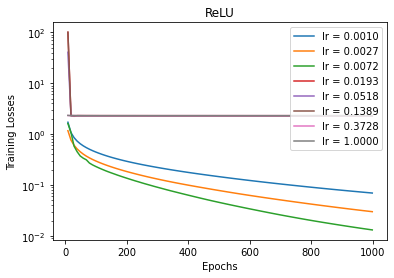

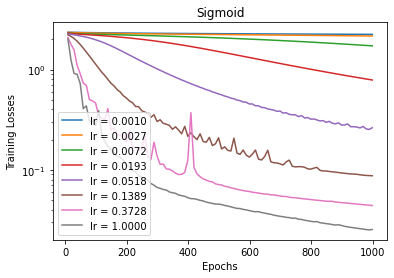

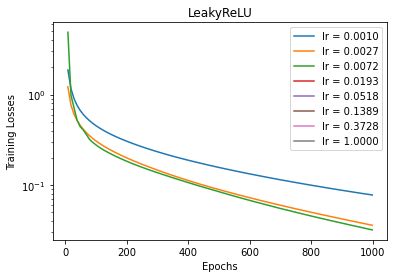

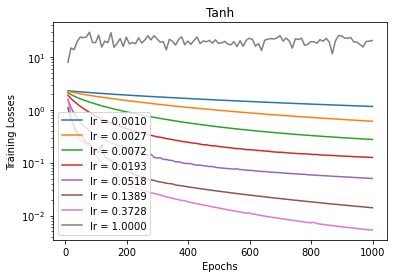

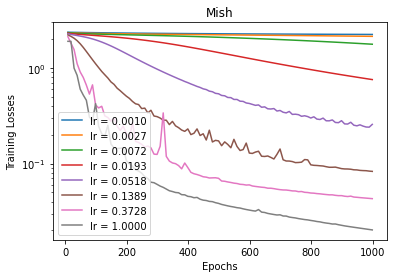

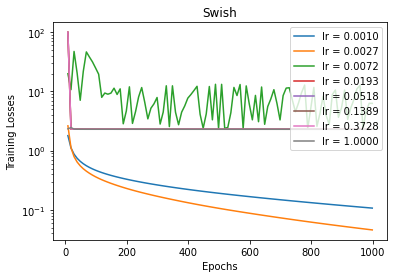

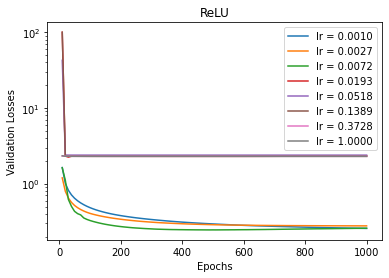

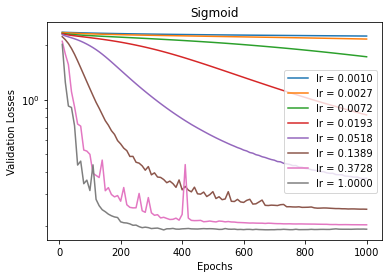

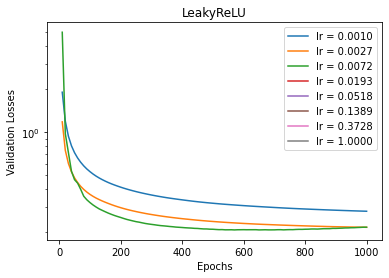

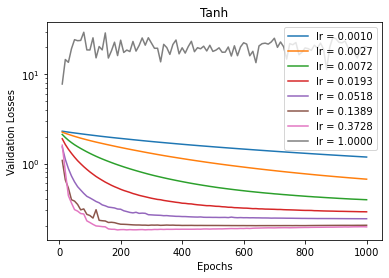

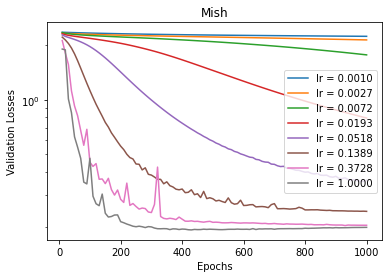

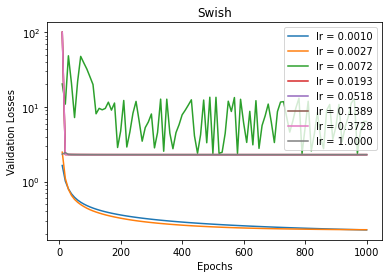

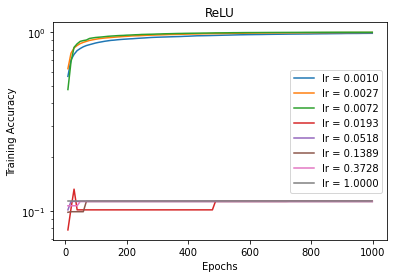

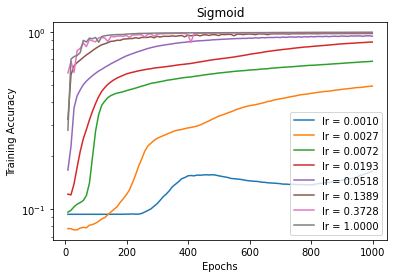

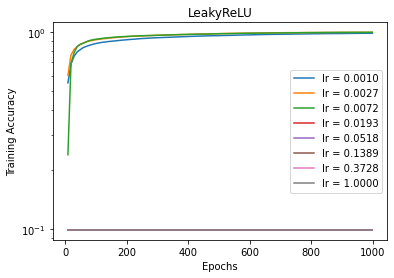

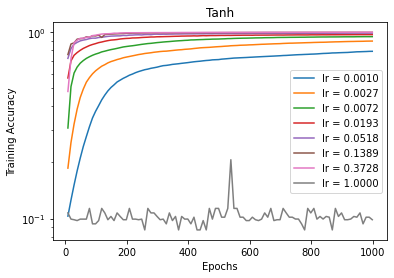

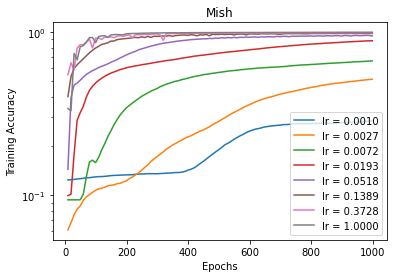

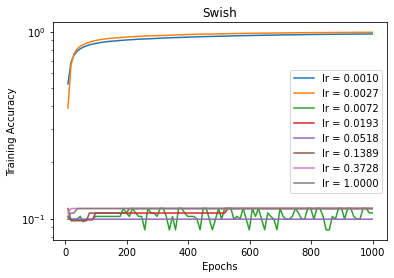

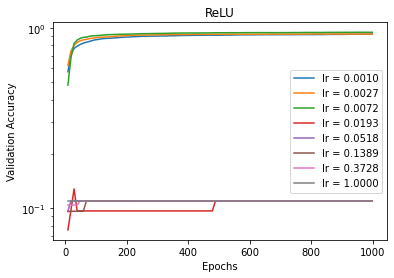

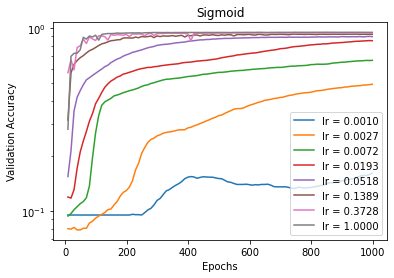

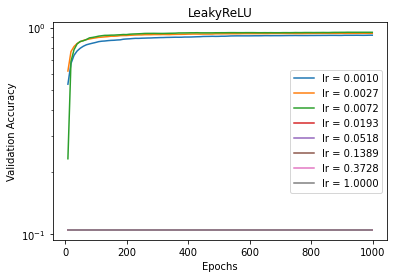

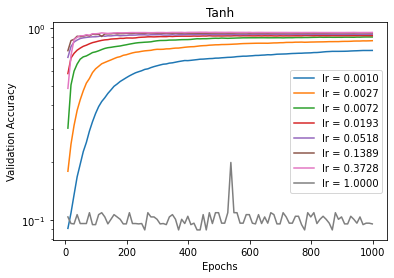

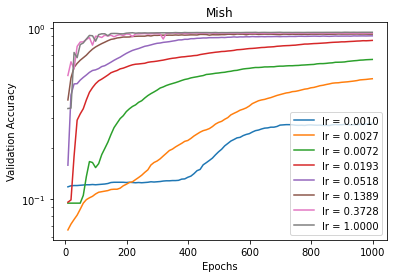

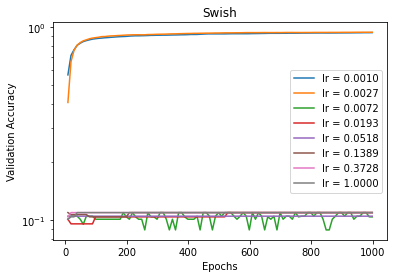

In [10]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, np.clip(losses[i,0,j], a_min = None, a_max = 100), label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Training Losses")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, np.clip(losses[i,1,j], a_min = None, a_max = 100), label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Validation Losses")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, accs[i,0,j], label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

for i, act in enumerate(activation_units):
    for j, lr in enumerate(learning_rates[i]):
        plt.plot(x_range, accs[i,1,j], label = "lr = {:1.4f}".format(lr))
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    #plt.ylim(0, 5)
    plt.yscale("log")
    plt.legend()
    plt.title(activation_strs[i])
    plt.show()

### **(f) Training using the best learning rate**
Using the best learning rate to train on the complete training set.

Compare the loss and accuracy during training.

Then report the test accuracy for each activation. 

In [11]:
X_trainall = torch.Tensor(mnist_subsetX)
Y_trainall = torch.from_numpy(mnist_subsetY)

epochs = 1000

models = []
losses = np.zeros((len(activation_units), 2, int(epochs/10)))
accs = np.zeros((len(activation_units), 2, int(epochs/10)))
###################################################### TODO F
learning_rate = [0.0027, 1.0, 0.0027, 0.3728, 0.3728, 0.001]
for i, act in enumerate(activation_units):
    print("Training with {} activation units".format(activation_strs[i]))

# Call the training function to get the model, loss and accuracy
    model, loss_train_his, loss_valid_his, acc_train_his, acc_valid_his = training(act, 
                200, 64, X_trainall, Y_trainall, learning_rate[i], epochs)
    models.append(model)
    losses[i,0,:] = np.array(loss_train_his)
    losses[i,1,:] = np.array(loss_valid_his)
    accs[i,0,:] = np.array(acc_train_his)
    accs[i,1,:] = np.array(acc_valid_his)
######################################################

Training with ReLU activation units
9 loss =  1.0768992900848389 acc =  0.6652500033378601 valid:  (1.0194400548934937, 0.6791666746139526)
19 loss =  0.7187633514404297 acc =  0.784333348274231 valid:  (0.6605185270309448, 0.7995833158493042)
29 loss =  0.5799684524536133 acc =  0.8297500014305115 valid:  (0.5305166840553284, 0.8387500047683716)
39 loss =  0.4965434968471527 acc =  0.8540833592414856 valid:  (0.4553312659263611, 0.85958331823349)
49 loss =  0.43885862827301025 acc =  0.8723333477973938 valid:  (0.4052700698375702, 0.8787500262260437)
59 loss =  0.3958098888397217 acc =  0.8855833411216736 valid:  (0.367582231760025, 0.8887500166893005)
69 loss =  0.3619694709777832 acc =  0.8965833187103271 valid:  (0.33777523040771484, 0.9012500047683716)
79 loss =  0.3341948390007019 acc =  0.903249979019165 valid:  (0.3129481077194214, 0.9075000286102295)
89 loss =  0.31095486879348755 acc =  0.9089166522026062 valid:  (0.29158538579940796, 0.9120833277702332)
99 loss =  0.29118278

769 loss =  0.046757105737924576 acc =  0.9917500019073486 valid:  (0.043953415006399155, 0.9925000071525574)
779 loss =  0.045949529856443405 acc =  0.9919166564941406 valid:  (0.043192408978939056, 0.9925000071525574)
789 loss =  0.04516666755080223 acc =  0.9919999837875366 valid:  (0.04245670512318611, 0.9925000071525574)
799 loss =  0.044398706406354904 acc =  0.9923333525657654 valid:  (0.04174189642071724, 0.9925000071525574)
809 loss =  0.0436520017683506 acc =  0.9926666617393494 valid:  (0.041038643568754196, 0.9929166436195374)
819 loss =  0.0429212711751461 acc =  0.9926666617393494 valid:  (0.04035085812211037, 0.9929166436195374)
829 loss =  0.04220905154943466 acc =  0.9929166436195374 valid:  (0.03966686502099037, 0.9933333396911621)
839 loss =  0.04151434451341629 acc =  0.9930833578109741 valid:  (0.03899236395955086, 0.9937499761581421)
849 loss =  0.04083459824323654 acc =  0.9934166669845581 valid:  (0.038350313901901245, 0.9941666722297668)
859 loss =  0.040173768

519 loss =  0.04531091824173927 acc =  0.9886666536331177 valid:  (0.037345387041568756, 0.9920833110809326)
529 loss =  0.04516034945845604 acc =  0.9887499809265137 valid:  (0.037587281316518784, 0.9916666746139526)
539 loss =  0.04421832785010338 acc =  0.9889166951179504 valid:  (0.03652103990316391, 0.9925000071525574)
549 loss =  0.0439530573785305 acc =  0.9890000224113464 valid:  (0.03641090914607048, 0.9925000071525574)
559 loss =  0.042908184230327606 acc =  0.9894999861717224 valid:  (0.03547428920865059, 0.9925000071525574)
569 loss =  0.04266435652971268 acc =  0.9894999861717224 valid:  (0.0350610688328743, 0.9925000071525574)
579 loss =  0.041681308299303055 acc =  0.9897500276565552 valid:  (0.03433069586753845, 0.9929166436195374)
589 loss =  0.04115504026412964 acc =  0.9897500276565552 valid:  (0.033897850662469864, 0.9929166436195374)
599 loss =  0.04129299148917198 acc =  0.9897500276565552 valid:  (0.03419085592031479, 0.9925000071525574)
609 loss =  0.04027254879

269 loss =  0.16766315698623657 acc =  0.95291668176651 valid:  (0.14634692668914795, 0.9587500095367432)
279 loss =  0.163079634308815 acc =  0.9546666741371155 valid:  (0.1421707719564438, 0.9612500071525574)
289 loss =  0.15871670842170715 acc =  0.9556666612625122 valid:  (0.13821181654930115, 0.9624999761581421)
299 loss =  0.1545628011226654 acc =  0.9574166536331177 valid:  (0.1344943642616272, 0.9637500047683716)
309 loss =  0.150581955909729 acc =  0.9586666822433472 valid:  (0.1309315413236618, 0.965833306312561)
319 loss =  0.1467560976743698 acc =  0.9599166512489319 valid:  (0.12751136720180511, 0.9666666388511658)
329 loss =  0.143105611205101 acc =  0.9610833525657654 valid:  (0.12421662360429764, 0.9679166674613953)
339 loss =  0.13961316645145416 acc =  0.9626666903495789 valid:  (0.12104731053113937, 0.9691666960716248)
349 loss =  0.13626457750797272 acc =  0.9635833501815796 valid:  (0.11800341308116913, 0.9691666960716248)
359 loss =  0.13305023312568665 acc =  0.9

19 loss =  0.6662798523902893 acc =  0.7883333563804626 valid:  (0.6492761969566345, 0.7920833230018616)
29 loss =  0.45390450954437256 acc =  0.8773333430290222 valid:  (0.43435612320899963, 0.8791666626930237)
39 loss =  0.34376901388168335 acc =  0.906333327293396 valid:  (0.3301571011543274, 0.9112499952316284)
49 loss =  0.27444252371788025 acc =  0.9260833263397217 valid:  (0.25704774260520935, 0.9279166460037231)
59 loss =  0.28616994619369507 acc =  0.9144166707992554 valid:  (0.26361632347106934, 0.9162499904632568)
69 loss =  0.22832635045051575 acc =  0.937583327293396 valid:  (0.21847882866859436, 0.9420833587646484)
79 loss =  0.18849655985832214 acc =  0.9494166374206543 valid:  (0.17552752792835236, 0.956250011920929)
89 loss =  0.16347476840019226 acc =  0.9555000066757202 valid:  (0.15353377163410187, 0.9591666460037231)
99 loss =  0.14452973008155823 acc =  0.9584166407585144 valid:  (0.13832201063632965, 0.9629166722297668)
109 loss =  0.14976708590984344 acc =  0.95

769 loss =  0.010122562758624554 acc =  0.9985833168029785 valid:  (0.009481316432356834, 0.9991666674613953)
779 loss =  0.009958479553461075 acc =  0.9985833168029785 valid:  (0.009330752305686474, 0.9991666674613953)
789 loss =  0.009799152612686157 acc =  0.9985833168029785 valid:  (0.009185847826302052, 0.9991666674613953)
799 loss =  0.009644030593335629 acc =  0.9985833168029785 valid:  (0.009050130844116211, 0.9991666674613953)
809 loss =  0.009492255747318268 acc =  0.9987499713897705 valid:  (0.008911889046430588, 0.9991666674613953)
819 loss =  0.009341931901872158 acc =  0.9987499713897705 valid:  (0.00877438671886921, 0.9991666674613953)
829 loss =  0.009197532199323177 acc =  0.9987499713897705 valid:  (0.008641169406473637, 0.9991666674613953)
839 loss =  0.009055702947080135 acc =  0.9987499713897705 valid:  (0.008518639951944351, 0.9991666674613953)
849 loss =  0.008915362879633904 acc =  0.9987499713897705 valid:  (0.008393603377044201, 0.9991666674613953)
859 loss = 

519 loss =  0.13050124049186707 acc =  0.9670000076293945 valid:  (0.12379717826843262, 0.9691666960716248)
529 loss =  0.09964552521705627 acc =  0.9778333306312561 valid:  (0.09159183502197266, 0.9791666865348816)
539 loss =  0.0848812535405159 acc =  0.9822499752044678 valid:  (0.0778675228357315, 0.9833333492279053)
549 loss =  0.08107399195432663 acc =  0.9832500219345093 valid:  (0.07379265874624252, 0.98458331823349)
559 loss =  0.08149242401123047 acc =  0.9829166531562805 valid:  (0.07447536289691925, 0.9858333468437195)
569 loss =  0.08254840970039368 acc =  0.9821666479110718 valid:  (0.07560321688652039, 0.9850000143051147)
579 loss =  0.07178128510713577 acc =  0.9850000143051147 valid:  (0.06513819098472595, 0.9879166483879089)
589 loss =  0.07037224620580673 acc =  0.9848333597183228 valid:  (0.0640636458992958, 0.9883333444595337)
599 loss =  0.0694044828414917 acc =  0.9854166507720947 valid:  (0.06274904310703278, 0.9887499809265137)
609 loss =  0.06676116585731506 ac

269 loss =  0.297221302986145 acc =  0.9123333096504211 valid:  (0.27062472701072693, 0.9275000095367432)
279 loss =  0.29184943437576294 acc =  0.9134166836738586 valid:  (0.265837699174881, 0.9279166460037231)
289 loss =  0.28669098019599915 acc =  0.9152500033378601 valid:  (0.26123836636543274, 0.9300000071525574)
299 loss =  0.28172820806503296 acc =  0.9170833230018616 valid:  (0.2568094730377197, 0.9312499761581421)
309 loss =  0.2769470512866974 acc =  0.9182500243186951 valid:  (0.2525382339954376, 0.9316666722297668)
319 loss =  0.2723357379436493 acc =  0.9190833568572998 valid:  (0.24841226637363434, 0.9320833086967468)
329 loss =  0.267879843711853 acc =  0.9211666584014893 valid:  (0.24442049860954285, 0.9329166412353516)
339 loss =  0.2635704278945923 acc =  0.922249972820282 valid:  (0.24055293202400208, 0.934166669845581)
349 loss =  0.25939783453941345 acc =  0.9235000014305115 valid:  (0.23680125176906586, 0.9350000023841858)
359 loss =  0.2553524374961853 acc =  0.9

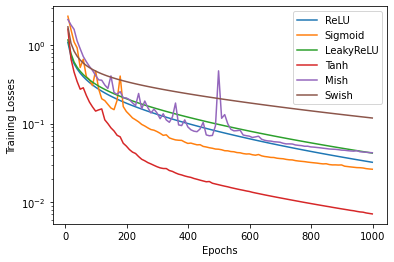

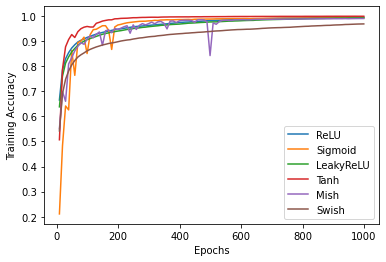

In [12]:
x_range = range(9, epochs, 10)
for i, act in enumerate(activation_units):
    plt.plot(x_range, losses[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Losses")
plt.yscale("log")
plt.legend()
plt.show()

for i, act in enumerate(activation_units):
    plt.plot(x_range, accs[i,0], label = activation_strs[i])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
#plt.yscale("log")
plt.legend()
plt.show()


In [13]:
# Report the accuracy on test set
###################################################### TODO
for i, model in enumerate(models):
    _, acc = test(model, X_test, Y_test)
    print("Accuracy of using {} activation units at learning rate {:1.4f}: {:1.4f}".format(activation_strs[i].rjust(9), learning_rate[i], acc))
###################################################### TODO

Accuracy of using      ReLU activation units at learning rate 0.0027: 0.9293
Accuracy of using   Sigmoid activation units at learning rate 1.0000: 0.9427
Accuracy of using LeakyReLU activation units at learning rate 0.0027: 0.9305
Accuracy of using      Tanh activation units at learning rate 0.3728: 0.9451
Accuracy of using      Mish activation units at learning rate 0.3728: 0.9343
Accuracy of using     Swish activation units at learning rate 0.0010: 0.9229
